In [13]:
import os
import sys
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.isotonic import IsotonicRegression
import random

In [2]:
dataset_name = 'Combined_Cycle_Power_Plant_Dataset'
n_thresholds = 32
classifier_folder = 'RandomForest_classifier'

In [188]:
class isotonic_regression_model():
    def __init__(self):
        super(isotonic_regression_model, self).__init__()
        self.thresholds_real_values = None
        self.n_thresholds = None
        self.values_between_thresholds = None
        
    def fit(self, thresholds_real_values):
        self.thresholds_real_values = thresholds_real_values
        self.n_thresholds = len(thresholds_real_values)
        
        self.values_between_thresholds = []
        for tmp_index in range(len(thresholds_real_values) - 1):
            self.values_between_thresholds.append((thresholds_real_values[tmp_index] + thresholds_real_values[tmp_index + 1]) / 2.0)
    
    def predict(self, X):
        predictions = []
        
        for classifiers_prediction in X:
            isotonic_regression_model = IsotonicRegression()
            isotonic_regression_model.fit(self.thresholds_real_values, classifiers_prediction)
            isotonic_prediction = isotonic_regression_model.predict(self.thresholds_real_values)
        
            differences = []
            for tmp_index in range(self.n_thresholds - 1):
                differences.append(isotonic_prediction[tmp_index + 1] - isotonic_prediction[tmp_index])
                
            weighted_mean = 0
            for yi, Pi in zip(self.values_between_thresholds, differences):
                weighted_mean += Pi * yi
                
            predictions.append(weighted_mean)
        
        return predictions
    
    def predict_largest_diff(self, X):
        predictions = []
        
        for classifiers_prediction in X:
            # No isotonic regression here
            differences = []
            for tmp_index in range(self.n_thresholds - 1):
                differences.append(classifiers_prediction[tmp_index + 1] - classifiers_prediction[tmp_index])
                
            predictions.append(self.values_between_thresholds[np.argmax(differences)])
        
        return predictions
    
    def predict_largest_diff_with_isotonic_regression(self, X):
        predictions = []
        
        for classifiers_prediction in X:
            isotonic_regression_model = IsotonicRegression()
            isotonic_regression_model.fit(self.thresholds_real_values, classifiers_prediction)
            isotonic_prediction = isotonic_regression_model.predict(self.thresholds_real_values)
        
            differences = []
            for tmp_index in range(self.n_thresholds - 1):
                differences.append(isotonic_prediction[tmp_index + 1] - isotonic_prediction[tmp_index])
                
            predictions.append(self.values_between_thresholds[np.argmax(differences)])
        
        return predictions
        
            
    def fit_predict(self, thresholds_real_values, X):
        self.fit(thresholds_real_values)
        return self.predict(X)
        
            
    def fit_predict_largest_diff(self, thresholds_real_values, X):
        self.fit(thresholds_real_values)
        return self.predict_largest_diff(X)

In [4]:
def load_datasets(path, name):
    folds_directories = [f.path for f in os.scandir(path) if name in f.path.split('_')]

    datasets_list = []

    for fold_path in folds_directories:
        datasets_list.append(pd.read_csv(fold_path))
        
    return datasets_list

In [47]:
split_0_thresholds_real_values = [
 -1.64903713, -1.48213775, -1.34932436, -1.23791729, -1.14045313, -1.0426418,
 -0.95044171, -0.86286024, -0.77755683, -0.69584382, -0.61276514, -0.51563182,
 -0.42969661, -0.33171858, -0.22501316, -0.11824968,  0.0065468,   0.12508521,
  0.2570924,   0.40129147,  0.53294442,  0.62902742,  0.71434348,  0.80378459,
  0.89288096,  0.99337665,  1.08873837,  1.18107694,  1.28890763,  1.38965359,
  1.50629066,  1.64602984
]

split_1_thresholds_real_values = [
 -1.64960359, -1.48552966, -1.35308836, -1.23662492, -1.13665712, -1.03945539,
 -0.9471198,  -0.86014557, -0.77757291, -0.69501119, -0.61111706, -0.51655528,
 -0.43179836, -0.33493871, -0.22613232, -0.1192303,   0.00510153,  0.12844131,
  0.25871129,  0.40069569,  0.53396968,  0.63314237,  0.71578989,  0.80139441,
  0.89219614,  0.99022027,  1.0869545,   1.1769188,   1.28826677,  1.38797967,
  1.505277,    1.6500434 ]

split_2_thresholds_real_values = [
 -1.64670987, -1.48654836, -1.35221934, -1.23790065, -1.13847454, -1.0402835,
 -0.94773873, -0.86129359, -0.77780808, -0.6908546,  -0.6089095,  -0.51349989,
 -0.42727437, -0.32962796, -0.224481,   -0.11920678, 0.00665003,  0.12558284,
  0.25572171,  0.40040973,  0.52899571,  0.62884327,  0.71080179,  0.79324971,
  0.88895699,  0.99123288,  1.08615775, 1.18128634,  1.29202286,  1.3928888,
  1.510493,    1.65051973]

split_3_thresholds_real_values = [
 -1.64694135, -1.48444873, -1.3565369,  -1.24118883, -1.14069584, -1.04146458,
 -0.94935487, -0.86040188, -0.77660388, -0.68796241, -0.60983866, -0.51680937,
 -0.42887094, -0.33477416, -0.22796482, -0.12046255,  0.00868737,  0.12552282,
  0.25766769,  0.41140187,  0.53603764,  0.63119068,  0.71561741,  0.80045896,
  0.88959645,  0.98899203,  1.08307808,  1.17743971,  1.28639724,  1.39041508,
  1.50748267,  1.65085442]

split_4_thresholds_real_values = [
 -1.64482385 ,-1.47784319 ,-1.3481702 , -1.23821142 ,-1.13755266, -1.04268381,
 -0.95110846 ,-0.86485901 ,-0.78084362, -0.69688187 ,-0.61300405, -0.5177782,
 -0.42906755 ,-0.33488296 ,-0.22356994, -0.11982345,  0.01054124,  0.12674226,
  0.25995018,  0.40966932,  0.53530418,  0.6324467,   0.71723984,  0.80090505,
  0.89134063,  0.99000315,  1.0868937 ,  1.17701372,  1.29147579,  1.38847941,
  1.5051769,   1.65173829]

split_5_thresholds_real_values = [
 -1.64203865 ,-1.48255543 ,-1.35279253 ,-1.24042542 ,-1.14053781 ,-1.04416602,
 -0.94894421 ,-0.86497555 ,-0.77890345 ,-0.69366634 ,-0.61199908 ,-0.51422483,
 -0.43098101 ,-0.33366723 ,-0.22382841 ,-0.11902946,  0.00865877,  0.12640966,
  0.26158174,  0.40647876,  0.5339824,   0.62877962,  0.71592913,  0.79984305,
  0.88949705,  0.99358508,  1.08908846,  1.17742734,  1.29117424,  1.3849276,
  1.50921071,  1.64981781]

split_6_thresholds_real_values = [
 -1.64978764, -1.48572307, -1.3516937, -1.23919908, -1.13766539, -1.039713,
 -0.94739273, -0.85898405, -0.77715956, -0.69462015, -0.61074627, -0.51485723,
 -0.42617329, -0.331374, -0.22770651, -0.1235387, 0.00364389, 0.12355166,
  0.25772208, 0.40945725, 0.53618409,  0.6312352, 0.71658136, 0.80178624,
  0.8917375, 0.98994408, 1.09063208, 1.17933816, 1.28753808, 1.38950857,
  1.50563355, 1.65232019]

split_7_thresholds_real_values = [
 -1.655621,   -1.4873162  ,-1.35517286 ,-1.23971156 ,-1.13835427 ,-1.03754064,
 -0.94538326 ,-0.85566113 ,-0.77254201 ,-0.68873818 ,-0.60843387 ,-0.5173218,
 -0.43123296 ,-0.33047721 ,-0.22424303 ,-0.11543186,  0.00896073,  0.12596603,
  0.25602217,  0.39902562,  0.52581155,  0.62710764,  0.71329263,  0.79932701,
  0.88962324,  0.99063202,  1.08602131,  1.17840348,  1.28369985,  1.38950239,
  1.50893534,  1.65848228]

split_8_thresholds_real_values = [
 -1.64688852 ,-1.48483569 ,-1.35132635 ,-1.23792232 ,-1.13869915 ,-1.04223907,
 -0.94620126 ,-0.85935401 ,-0.77264298, -0.6896141  ,-0.60734493 ,-0.51159203,
 -0.42907556 ,-0.33106591 ,-0.22620906 ,-0.12559369,  0.0055466,   0.12412165,
  0.25502825,  0.39817065,  0.52655596,  0.63164132,  0.71526404,  0.79952572,
  0.89492073,  0.99394093,  1.08666186,  1.17779457,  1.29265375,  1.3904384,
  1.50750657,  1.64904808]

split_9_thresholds_real_values = [
 -1.63374073 ,-1.48680494 ,-1.35411495 ,-1.24057255 ,-1.14112419 ,-1.04291243,
 -0.95034939 ,-0.86025897, -0.7753964  ,-0.69132042 ,-0.60940011 ,-0.5140205,
 -0.42782327 ,-0.33345279 ,-0.22636871 ,-0.11924786,  0.00593893,  0.12482047,
  0.25489937,  0.40502659,  0.53365204,  0.6299165,   0.71589109,  0.79917661,
  0.89171335,  0.99094141,  1.08483583,  1.17989198,  1.29053962,  1.39132018,
  1.50797069,  1.65076139]

splits_thresholds_real_values = [
    split_0_thresholds_real_values,
    split_1_thresholds_real_values,
    split_2_thresholds_real_values,
    split_3_thresholds_real_values,
    split_4_thresholds_real_values,
    split_5_thresholds_real_values,
    split_6_thresholds_real_values,
    split_7_thresholds_real_values,
    split_8_thresholds_real_values,
    split_9_thresholds_real_values
]

In [41]:
TRAIN_splits_extracted_features_dataset = load_datasets(os.path.join('..', 'data', 'extracted_features', dataset_name, str(n_thresholds) + '_bins_equal_freq_below_threshold', classifier_folder), 'TRAIN')
TEST_splits_extracted_features_dataset = load_datasets(os.path.join('..', 'data', 'extracted_features', dataset_name, str(n_thresholds) + '_bins_equal_freq_below_threshold', classifier_folder), 'TEST')

In [55]:
custom_model_train_rmses = []
custom_model_test_rmses = []

custom_model_train_rmses_2 = []
custom_model_test_rmses_2 = []

lr_train_rmses = []
lr_test_rmses = []

for i in range(10):
    print("===== Split " + str(i) + " :")
    
    split_i_TRAIN_dataset = TRAIN_splits_extracted_features_dataset[i]
    split_i_TRAIN_thresholds_prediction = []
    for class_col in [e for e in split_i_TRAIN_dataset.columns if 'threshold' in e.split('_') and '1|X)' in e.split('_')]:
        split_i_TRAIN_thresholds_prediction.append(list(split_i_TRAIN_dataset[class_col]))
    split_i_TRAIN_thresholds_prediction = np.array(split_i_TRAIN_thresholds_prediction).T
    
    split_i_TEST_dataset = TEST_splits_extracted_features_dataset[i]
    split_i_TEST_thresholds_prediction = []
    for class_col in [e for e in split_i_TEST_dataset.columns if 'threshold' in e.split('_') and '1|X)' in e.split('_')]:
        split_i_TEST_thresholds_prediction.append(list(split_i_TEST_dataset[class_col]))
    split_i_TEST_thresholds_prediction = np.array(split_i_TEST_thresholds_prediction).T

    custom_model_train_rmses.append(mean_squared_error(list(split_i_TRAIN_dataset['reg_goal_var']),
                                                       isotonic_regression_model().fit_predict(splits_thresholds_real_values[i],
                                                                                               split_i_TRAIN_thresholds_prediction),
                                                       squared=False))
    print("Custom model normal TRAIN RMSE =      {0:.3f}".format(custom_model_train_rmses[-1]))
    
    custom_model_test_rmses.append(mean_squared_error(list(split_i_TEST_dataset['reg_goal_var']),
                                                       isotonic_regression_model().fit_predict(splits_thresholds_real_values[i],
                                                                                               split_i_TEST_thresholds_prediction),
                                                       squared=False))
    print("Custom model normal TEST RMSE =       {0:.3f}".format(custom_model_test_rmses[-1]))
    
    
    
    
    # ========== 
    custom_model_train_rmses_2.append(mean_squared_error(list(split_i_TRAIN_dataset['reg_goal_var']),
                                                       isotonic_regression_model().fit_predict_largest_diff(splits_thresholds_real_values[i],
                                                                                               split_i_TRAIN_thresholds_prediction),
                                                       squared=False))
    print("Custom model largest diff TRAIN RMSE =    {0:.3f}".format(custom_model_train_rmses_2[-1]))
    
    custom_model_test_rmses_2.append(mean_squared_error(list(split_i_TEST_dataset['reg_goal_var']),
                                                       isotonic_regression_model().fit_predict_largest_diff(splits_thresholds_real_values[i],
                                                                                               split_i_TEST_thresholds_prediction),
                                                       squared=False))
    print("Custom model largest diff TEST RMSE =     {0:.3f}".format(custom_model_test_rmses_2[-1]))
    
    
    
    

    lr_model = LinearRegression().fit(split_i_TRAIN_thresholds_prediction, split_i_TRAIN_dataset['reg_goal_var'])
    
    lr_train_rmses.append(mean_squared_error(list(split_i_TRAIN_dataset['reg_goal_var']),
                                             lr_model.predict(split_i_TRAIN_thresholds_prediction),
                                             squared=False))
    
    lr_test_rmses.append(mean_squared_error(list(split_i_TEST_dataset['reg_goal_var']),
                                             lr_model.predict(split_i_TEST_thresholds_prediction),
                                             squared=False))
    
    
    
    
    
    print("Linear regression TRAIN RMSE = {0:.3f}".format(lr_train_rmses[-1]))

    print("Linear regression TEST RMSE =  {0:.3f}".format(lr_test_rmses[-1]))
    
print('\n================\n')
print("Custom model mean normal train rmse :       {0:.3f}".format(np.mean(custom_model_train_rmses)))
print("Custom model mean normal test rmse :        {0:.3f}".format(np.mean(custom_model_test_rmses)))
print("Custom model mean largest diff train rmse : {0:.3f}".format(np.mean(custom_model_train_rmses_2)))
print("Custom model mean largest diff test rmse :  {0:.3f}".format(np.mean(custom_model_test_rmses_2)))
print("Linear regression mean train rmse :         {0:.3f}".format(np.mean(lr_train_rmses)))
print("Linear regression mean test rmse :          {0:.3f}".format(np.mean(lr_test_rmses)))

===== Split 0 :
Custom model normal TRAIN RMSE =      0.397
Custom model normal TEST RMSE =       0.365
Custom model largest diff TRAIN RMSE =    0.144
Custom model largest diff TEST RMSE =     0.232
Linear regression TRAIN RMSE = 0.076
Linear regression TEST RMSE =  0.220
===== Split 1 :
Custom model normal TRAIN RMSE =      0.398
Custom model normal TEST RMSE =       0.422
Custom model largest diff TRAIN RMSE =    0.156
Custom model largest diff TEST RMSE =     0.249
Linear regression TRAIN RMSE = 0.076
Linear regression TEST RMSE =  0.200
===== Split 2 :
Custom model normal TRAIN RMSE =      0.399
Custom model normal TEST RMSE =       0.386
Custom model largest diff TRAIN RMSE =    0.162
Custom model largest diff TEST RMSE =     0.235
Linear regression TRAIN RMSE = 0.077
Linear regression TEST RMSE =  0.205
===== Split 3 :
Custom model normal TRAIN RMSE =      0.396
Custom model normal TEST RMSE =       0.419
Custom model largest diff TRAIN RMSE =    0.151
Custom model largest diff 

In [101]:
TRAIN_splits_extracted_features_dataset = load_datasets(os.path.join('..', 'data', 'extracted_features', dataset_name, str(10) + '_bins_equal_freq_below_threshold', classifier_folder), 'TRAIN')
TEST_splits_extracted_features_dataset = load_datasets(os.path.join('..', 'data', 'extracted_features', dataset_name, str(10) + '_bins_equal_freq_below_threshold', classifier_folder), 'TEST')

index = 2952
real Y value :   1.222
largest_diff_pred. : 1.238 (diff = 0.016)
weighted_mean_pred. : 1.153 (diff = 0.069)


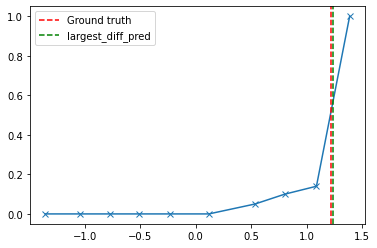

In [178]:
test_10_thresholds_dataset = TRAIN_splits_extracted_features_dataset[0]
test_10_thresholds_thresholds_prediction = []
for class_col in [e for e in test_10_thresholds_dataset.columns if 'threshold' in e.split('_') and '1|X)' in e.split('_')]:
    test_10_thresholds_thresholds_prediction.append(list(test_10_thresholds_dataset[class_col]))
test_10_thresholds_prediction = np.array(test_10_thresholds_thresholds_prediction).T

rand_index = random.randint(0, len(test_10_thresholds_prediction))
print('index =', rand_index)

y0 = test_10_thresholds_prediction[rand_index]

model = isotonic_regression_model()
model.fit(ten_bins_split_zero)

largest_diff_pred = model.predict_largest_diff([y0])[0]
weighted_mean_pred = model.predict([y0])[0]
    
print('real Y value :   {0:.3f}'.format(test_10_thresholds_dataset.iloc[rand_index]['reg_goal_var']))

print('largest_diff_pred. : {0:.3f}'.format(largest_diff_pred), '(diff = {0:.3f})'.format(np.abs(largest_diff_pred - test_10_thresholds_dataset.iloc[rand_index]['reg_goal_var'])))
print('weighted_mean_pred. : {0:.3f}'.format(weighted_mean_pred), '(diff = {0:.3f})'.format(np.abs(weighted_mean_pred - test_10_thresholds_dataset.iloc[rand_index]['reg_goal_var'])))

plt.plot(ten_bins_split_zero, y0, marker='x')
plt.axvline(x=test_10_thresholds_dataset.iloc[rand_index]['reg_goal_var'], color='red', linestyle='--', label='Ground truth')
plt.axvline(x=largest_diff_pred, color='green', linestyle='--', label='largest_diff_pred')
# plt.axvline(x=weighted_mean_pred, color='blue', linestyle='--', label='weighted_mean_pred')
plt.legend()

In [160]:
test_hundred_dataset = load_datasets(os.path.join('..', 'data', 'extracted_features', dataset_name, '100_bins_equal_freq_below_threshold', classifier_folder), 'TRAIN')[0]

In [161]:
test_hundred_thresholds_classifiers_prediction = []
for class_col in [e for e in test_hundred_dataset.columns if 'threshold' in e.split('_') and '1|X)' in e.split('_')]:
    test_hundred_thresholds_classifiers_prediction.append(list(test_hundred_dataset[class_col]))
test_hundred_thresholds_classifiers_prediction = np.array(test_hundred_thresholds_classifiers_prediction).T

In [162]:
test_hundred_thresholds_classifiers_prediction.shape

(8611, 100)

In [163]:
hundred_thresholds_real_values = [
 -1.86602464, -1.73423924, -1.65525863, -1.5779327 , -1.53762595, -1.49018475,
 -1.44155526, -1.39909078, -1.36183035, -1.3208492 , -1.28735673, -1.25014845,
 -1.21400598, -1.17968553, -1.14560716, -1.11790291, -1.08578162, -1.05463101,
 -1.01766592, -0.98919458, -0.96163475, -0.93128059, -0.90772346, -0.87479286,
 -0.84281393, -0.81608902, -0.79309702, -0.76237722, -0.73539557, -0.70856816,
 -0.67909449, -0.64702561, -0.62208107, -0.59589487, -0.55961665, -0.53445747,
 -0.50269442, -0.47717234, -0.44779584, -0.41860565, -0.38828566, -0.35555504,
 -0.32435246, -0.28757437, -0.25236617, -0.22249391, -0.18904269, -0.15833469,
 -0.12163496, -0.08216057, -0.03208623,  0.00721246,  0.0437805 ,  0.0841937,
  0.11720099,  0.15986201,  0.20038612,  0.24339462,  0.28598557,  0.3376702,
  0.3870928 ,  0.43432097,  0.46913608,  0.51762441,  0.55814877,  0.582492,
  0.61770258,  0.64898991,  0.67540469,  0.70499054,  0.73589891,  0.76228562,
  0.78901125,  0.8175661 ,  0.84444048,  0.87853151,  0.90697468,  0.93474014,
  0.97388097,  1.00407125,  1.03546531,  1.06615274,  1.10034738,  1.12870493,
  1.16054743,  1.18575324,  1.21488953,  1.26179685,  1.29795959,  1.33226062,
  1.3649621 ,  1.39371289,  1.43194568,  1.47024384,  1.51176321,  1.55827442,
  1.59992173,  1.65701456,  1.72788622,  1.81627275
]

In [164]:
hundred_thresholds_prediction = isotonic_regression_model().fit_predict(hundred_thresholds_real_values,
                                                           test_hundred_thresholds_classifiers_prediction)
print("Custom model TRAIN RMSE =      {0:.3f}".format(mean_squared_error(list(test_hundred_dataset['reg_goal_var']),
                                                                         hundred_thresholds_prediction,
                                                                         squared=False)))

Custom model TRAIN RMSE =      0.236


In [165]:
hundred_thresholds_prediction_largest_diff = isotonic_regression_model().fit_predict_largest_diff(hundred_thresholds_real_values,
                                                                                                  test_hundred_thresholds_classifiers_prediction)
print("Custom model TRAIN RMSE =      {0:.3f}".format(mean_squared_error(list(test_hundred_dataset['reg_goal_var']),
                                                                         hundred_thresholds_prediction_largest_diff,
                                                                         squared=False)))

Custom model TRAIN RMSE =      0.064


In [166]:
values_between_thresholds = []
for tmp_index in range(len(hundred_thresholds_real_values) - 1):
    values_between_thresholds.append((hundred_thresholds_real_values[tmp_index] + hundred_thresholds_real_values[tmp_index + 1]) / 2.0)

index = 545
real Y value :   0.828
predicted mean : 0.801 (diff = 0.027)
Largest diff :   0.818 (diff = 0.010)


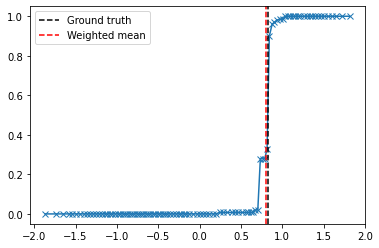

In [167]:
rand_index = random.randint(0, len(test_hundred_thresholds_classifiers_prediction))
print('index =', rand_index)

y0 = test_hundred_thresholds_classifiers_prediction[rand_index]

model = IsotonicRegression().fit(hundred_thresholds_real_values, y0)

model_prediction_for_all_the_thresholds = model.predict(hundred_thresholds_real_values)

differences = []
for tmp_index in range(len(model_prediction_for_all_the_thresholds) - 1):
    differences.append(model_prediction_for_all_the_thresholds[tmp_index + 1] - model_prediction_for_all_the_thresholds[tmp_index])

custom_prediction = np.sum([e1 * e2 for e1, e2 in zip(values_between_thresholds, differences)]) / sum(differences)
    
print('real Y value :   {0:.3f}'.format(test_hundred_dataset.iloc[rand_index]['reg_goal_var']))

print('predicted mean : {0:.3f}'.format(custom_prediction), '(diff = {0:.3f})'.format(np.abs(custom_prediction - test_hundred_dataset.iloc[rand_index]['reg_goal_var'])))
print('Largest diff :   {0:.3f}'.format(hundred_thresholds_real_values[np.argmax(differences)]), '(diff = {0:.3f})'.format(np.abs(hundred_thresholds_real_values[np.argmax(differences)] - test_hundred_dataset.iloc[rand_index]['reg_goal_var'])))

plt.plot(hundred_thresholds_real_values, model_prediction_for_all_the_thresholds, marker='x')
plt.axvline(x=test_hundred_dataset.iloc[rand_index]['reg_goal_var'], color='k', linestyle='--', label='Ground truth')
plt.axvline(x=custom_prediction, color='r', linestyle='--', label='Weighted mean')
plt.legend()

<AxesSubplot:xlabel='x', ylabel='y'>

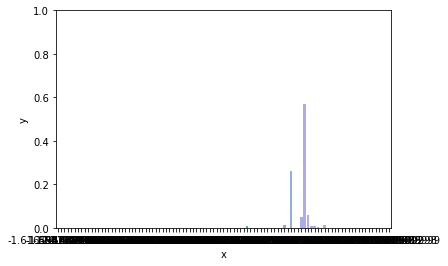

In [168]:
fig, (axes) = plt.subplots(1, 1) #, figsize=(10, 10)
axes.set_ylim([0, 1])
sns.barplot(x='x', y='y', data = pd.DataFrame({'x': values_between_thresholds, 'y': differences}))

In [47]:
custom_predictions = []
largest_diff_predictions = []

for classfiers_predictions in test_hundred_thresholds_classifiers_prediction:
    model = IsotonicRegression().fit(hundred_thresholds_real_values, classfiers_predictions)

    model_prediction_for_all_the_thresholds = model.predict(hundred_thresholds_real_values)

    differences = []
    for tmp_index in range(len(model_prediction_for_all_the_thresholds) - 1):
        differences.append(model_prediction_for_all_the_thresholds[tmp_index + 1] - model_prediction_for_all_the_thresholds[tmp_index])

    custom_prediction = np.sum([e1 * e2 for e1, e2 in zip(values_between_thresholds, differences)])
    
    custom_predictions.append(custom_prediction)
    
    largest_diff_predictions.append(hundred_thresholds_real_values[np.argmax(differences)])

In [48]:
# Weighted mean prediction mean absolute difference
np.mean(np.abs(custom_predictions - test_hundred_dataset['reg_goal_var']))

0.08537462553254202

In [49]:
# Largest diff prediction mean absolute difference
np.mean(np.abs(largest_diff_predictions - test_hundred_dataset['reg_goal_var']))

0.025845291495761164

In [51]:
# Weighted mean prediction RMSE
mean_squared_error(test_hundred_dataset['reg_goal_var'],
                   custom_predictions,
                   squared=False)

0.24107182134912042

In [52]:
# Largest diff prediction RMSE
mean_squared_error(test_hundred_dataset['reg_goal_var'],
                   largest_diff_predictions,
                   squared=False)

0.08090332758204946

# Experiments for curve

In [5]:
ten_bins_split_zero = [-1.354126177615588, -1.0403732539324109, -0.7738191814215427, -0.5142263003490398, -0.22840953528484387, 0.11962830346777621, 0.5342710381760571, 0.8036986731268566, 1.088755056011404, 1.3880088336581862]
ten_bins_split_one = [-1.3520165183190742, -1.039376020042385, -0.7801910410516859, -0.5153432699888746, -0.22447607692510216, 0.1249758133991802, 0.5338664895790004, 0.7982759297111799, 1.0902036314879777, 1.3885962034403894]
ten_bins_split_two = [-1.34792889988152, -1.0457437903398092, -0.7817060062139464, -0.5166210562785782, -0.22567963322676782, 0.12885073085221593, 0.537335318160731, 0.8042229327074033, 1.0858420932908202, 1.388667897335511]
ten_bins_split_three = [-1.3543336109817203, -1.0397729178905046, -0.7707564336927063, -0.5128001415348427, -0.2288491404045478, 0.12736675070951176, 0.5269415156619826, 0.7958644233901543, 1.0877600791891806, 1.3934237773071854]
ten_bins_split_four = [-1.3552949544773267, -1.0398001563554784, -0.7776997451097525, -0.5130898336363163, -0.2226130324261117, 0.12796055657948713, 0.5289315236661247, 0.800795995417028, 1.0877741097603444, 1.391011229325469]
ten_bins_split_five = [-1.3533828605493412, -1.0384338319081057, -0.7769277260543169, -0.5176438259997282, -0.22371400241755723, 0.12444283392948238, 0.5319637268828517, 0.7994092505138438, 1.0914248786418765, 1.389572646177069]
ten_bins_split_six = [-1.3551509158282262, -1.0381772299145742, -0.7766303996501414, -0.5144033115690341, -0.220183426931927, 0.12273424628607067, 0.5319903724092192, 0.8003394730916242, 1.0829291267741883, 1.388323763948149]
ten_bins_split_seven = [-1.3536776174826755, -1.0435595547126417, -0.7778838870850587, -0.5115124047238556, -0.2246426441070432, 0.12267842516958802, 0.5278974408242747, 0.8016874163546293, 1.0851477221374788, 1.3906475841091903]
ten_bins_split_eight = [-1.3520691173352068, -1.0434220736657411, -0.778572159445549, -0.5180983142404215, -0.22800118241852288, 0.13067661598824945, 0.5353540755831862, 0.7983021077910673, 1.0864985814820844, 1.3877365097956127]
ten_bins_split_nince = [-1.3546788449731662, -1.0384777230522593, -0.7764193124755263, -0.5131662989849324, -0.22764860756646899, 0.12581792009337803, 0.5355318155283486, 0.798926114484785, 1.0811224973177094, 1.3921473701926068]
ten_bins_split_list = [ten_bins_split_zero, ten_bins_split_one, ten_bins_split_two, ten_bins_split_three, ten_bins_split_four, ten_bins_split_five, ten_bins_split_six, ten_bins_split_seven, ten_bins_split_eight, ten_bins_split_nince]

twenty_bins_split_zero = [-1.5472700978112148, -1.3317429150440674, -1.160957358931979, -1.0110581910635483, -0.8723059834276241, -0.7460486621408102, -0.6092603210256029, -0.46498565398997327, -0.3173135040699008, -0.1517172095942156, 0.037762813618135826, 0.23211288562067758, 0.4540311820360141, 0.6338324547670575, 0.7650013562613851, 0.9069144197203995, 1.0597438629353546, 1.2057291315044179, 1.3746920975996542, 1.5698024979799068]
twenty_bins_split_one = [-1.5493132302528, -1.3327346261962276, -1.162436398692642, -1.0137057975378554, -0.8738488680219592, -0.7422650446079907, -0.612895492461285, -0.4696114588478477, -0.32028325938094415, -0.1525513953038113, 0.04542101870512005, 0.23953955354623038, 0.45572278596196353, 0.6283398660798756, 0.7655419986408261, 0.9052992049534103, 1.0608718277239697, 1.2049155502395479, 1.3743274643227736, 1.5624611443399476]
twenty_bins_split_two = [-1.544251801611081, -1.339576804117391, -1.169092449379638, -1.0132656848605552, -0.8745680763388457, -0.7383489545050776, -0.6079617019914938, -0.4657774214695262, -0.32133483245214073, -0.15261194540203568, 0.039984079942240264, 0.23729232869002226, 0.4589134905208781, 0.6310496095495828, 0.7689882552913864, 0.9060893996880288, 1.060686143783549, 1.206203031597524, 1.3723118207545921, 1.5618170530336681]
twenty_bins_split_three = [-1.5463254118895136, -1.3334018929046016, -1.1660059552286715, -1.0152914838986802, -0.87561260463019, -0.7454941597791596, -0.6143482526335966, -0.46538962701160924, -0.319379330664323, -0.15471169546628122, 0.04260627657911761, 0.24545682742343472, 0.45646557601729276, 0.6308163464454591, 0.7621415152185336, 0.9041350488580613, 1.0567982717452136, 1.2007613856922723, 1.375513363840907, 1.5651424809969707]
twenty_bins_split_four = [-1.5490210334817691, -1.332388282121288, -1.1612474530856058, -1.0094627333355481, -0.8696355092186205, -0.7387800404257381, -0.6052673630799967, -0.46477073742778063, -0.3193547682777419, -0.15463435441856563, 0.03611885127715927, 0.22935852791709352, 0.45326601477551165, 0.6276462489069543, 0.7613880604216854, 0.9052399781253455, 1.059892205078521, 1.2080541322304303, 1.3777211432824439, 1.5647494642359885]
twenty_bins_split_five = [-1.551996957866601, -1.3351855467884253, -1.1615748328931035, -1.012293497575519, -0.8752926901613391, -0.7433885373210871, -0.6094534175467698, -0.46711777294607737, -0.3082240091896134, -0.14385249684325555, 0.04556423276784605, 0.24139605227001953, 0.45506035279059776, 0.6240571849265617, 0.7553780546900459, 0.898362725305065, 1.0551200113355703, 1.203731722641768, 1.3746695473084634, 1.5668418406754085]
twenty_bins_split_six = [-1.5458170799584532, -1.3332621492317858, -1.1630579943110502, -1.0133969430161818, -0.8754119830253868, -0.746174097076004, -0.610718472280331, -0.4690194726346719, -0.3198341220882236, -0.15158385112304795, 0.04483554018873576, 0.24002809055009877, 0.454961348216565, 0.6324170243495169, 0.7600908650431635, 0.9057865092783635, 1.0600158114812832, 1.2015656474283558, 1.3718871989489885, 1.560859837321192]
twenty_bins_split_seven = [-1.5466756700934603, -1.3369615504507617, -1.166592071236384, -1.012439230078622, -0.875397446702866, -0.7442971597795687, -0.6112289262898016, -0.46981524864583896, -0.32094070686366055, -0.15115535351206272, 0.04421107831038175, 0.2388631051584033, 0.45638445451563914, 0.630350040901123, 0.762831638137448, 0.9052944082982975, 1.0572959352298823, 1.2060243463554357, 1.375016025524809, 1.562414678383381]
twenty_bins_split_eight= [-1.5475908649099623, -1.3380065107832817, -1.1663378703181366, -1.007278371355286, -0.8678454378962748, -0.7415816248959227, -0.611033335428957, -0.46865076666009553, -0.32080840737251837, -0.15570779278896874, 0.037769295985863094, 0.23752263840005358, 0.45586990174751724, 0.6284125178275888, 0.7645548022001022, 0.9077253181177691, 1.0636382541680178, 1.2080047001328889, 1.3748460359769608, 1.5635247481875472]
twenty_bins_split_nince = [-1.5452268226862227, -1.332032019991304, -1.16461841702428, -1.012480455847583, -0.8744332238469348, -0.7437883565843789, -0.6111253882121029, -0.4660437567918452, -0.3156276375831921, -0.1530730185177158, 0.042914497899335324, 0.23647900098049057, 0.45697700702898936, 0.6335952227873721, 0.7623879295480851, 0.9021973161210819, 1.0548916252697549, 1.2049864380841822, 1.3775784229057986, 1.5671503050587834]
twenty_bins_split_list = [twenty_bins_split_zero, twenty_bins_split_one, twenty_bins_split_two, twenty_bins_split_three, twenty_bins_split_four, twenty_bins_split_five, twenty_bins_split_six, twenty_bins_split_seven, twenty_bins_split_eight, twenty_bins_split_nince]

thirty_bins_split_zero = [-1.6226575806142673, -1.4561868417949868, -1.3259159349797316, -1.2136846021866714, -1.1096354037827023, -1.004019857071908, -0.9155846371711062, -0.8186950147389225, -0.7328411334816253, -0.6374482650904668, -0.5452719046890797, -0.4521938304632013, -0.3427354826160742, -0.233868856029859, -0.12253622781289727, 0.014470304704967182, 0.14401308487955705, 0.2852663410036317, 0.43537862370936237, 0.5657742582849519, 0.6608575285713989, 0.748842056382449, 0.8405855079915947, 0.9421473170725492, 1.0480413207057706, 1.1532437234593798, 1.2604396712408268, 1.3702806951000088, 1.4867642128344287, 1.6329007844941663]
thirty_bins_split_one = [-1.624155172321395, -1.4592250141417984, -1.3316203221032388, -1.209607302990595, -1.104348042697159, -1.001338459386388, -0.9115165108788892, -0.81542454805992, -0.7297302710718381, -0.6316885112753416, -0.5404161858504561, -0.4489038108815632, -0.34481806149405103, -0.23222726359143164, -0.12297659784219223, 0.013881555734635221, 0.13673529341464324, 0.2699288645045781, 0.42504179872500814, 0.5610181704364798, 0.6586968418256975, 0.7516523447118155, 0.8431117856668255, 0.9467169899924279, 1.051602430520778, 1.1520557040917274, 1.2618175984276303, 1.371769273012819, 1.4894487673476018, 1.6432109407082078]
thirty_bins_split_two = [-1.6263739700935016, -1.4589826344649683, -1.3307445187654547, -1.2142880384329944, -1.1073670512973557, -1.005714089566388, -0.9141810824983663, -0.8207625128686087, -0.729125866662361, -0.6343833336571753, -0.5414940148930878, -0.44774421039946266, -0.3396057000753474, -0.2339190178861838, -0.12285670073448612, 0.012074162784222105, 0.14108303660208993, 0.2812391585725275, 0.4373911077389307, 0.5660080794481284, 0.6573338987659322, 0.7472971881389061, 0.8374267123732576, 0.937654535079611, 1.0450950213098844, 1.1491919319026254, 1.2598153729672092, 1.3724244051133379, 1.4912450376504718, 1.6360817267814047]
thirty_bins_split_three = [-1.6295258073928378, -1.4638674470594197, -1.3299541716477044, -1.2081983686462412, -1.103159658578442, -0.9988683152280282, -0.9099916608643819, -0.8162653886603102, -0.7300076129316712, -0.6342154657808747, -0.5417023450893532, -0.450993464788482, -0.34379094460249815, -0.23522252868692017, -0.12390910267338211, 0.009461560355972247, 0.13869333375946513, 0.27165834793420174, 0.42818127466464617, 0.5655276288515406, 0.6619963018415237, 0.750766117716138, 0.8427031528351568, 0.9458093609679105, 1.0483494504098663, 1.15490421240291, 1.2623947307585248, 1.3706610574678604, 1.4927473330706813, 1.638006520128156]
thirty_bins_split_four = [-1.6327805941256148, -1.466693719888399, -1.3274856092365956, -1.2092161600707105, -1.10440504236457, -1.0003173225583548, -0.9094000868477775, -0.8137115967469402, -0.7269490072161764, -0.6320670341387745, -0.5397362586975083, -0.44985571316731876, -0.34346308113450497, -0.23438936250575595, -0.12599035913650042, 0.007630619040320703, 0.13507350900891052, 0.2743086124979781, 0.42903755656359255, 0.5604886761668147, 0.6544576804181215, 0.7494743717290835, 0.8409406060795521, 0.943124220149886, 1.0509490702155886, 1.153304572686035, 1.2644588280272453, 1.3709504024694252, 1.4892397419668826, 1.6408270440755288]
thirty_bins_split_five = [-1.625963110337258, -1.456602090158273, -1.3289919761510802, -1.2092823349295072, -1.1068961049728756, -1.0051391186268965, -0.9149967471693445, -0.8157567737500666, -0.7305015433312083, -0.6336329252486079, -0.5434556206426222, -0.44967861668719766, -0.34023967163246427, -0.23460483388884332, -0.12578789963903136, 0.0075664101088724, 0.13008501726659516, 0.27257683910584024, 0.4313965571502675, 0.5661864934243338, 0.6577464837756275, 0.750441915698254, 0.8476151730191301, 0.9551882896415462, 1.0558461652734539, 1.155062294975663, 1.259154626159332, 1.3689982871425395, 1.4836275225346944, 1.6374616912578848]
thirty_bins_split_six = [-1.6198331965699593, -1.4623316468477268, -1.3311908038774787, -1.20967886733355, -1.10711071591354, -1.004419721976697, -0.9126545414386564, -0.8182954011594981, -0.7314074667468613, -0.6356954673416721, -0.541886093367859, -0.44792221893881157, -0.3428044344369523, -0.2355751690246089, -0.12428090900095705, 0.01450468730077336, 0.14011033756078556, 0.284975779576761, 0.43292843981554385, 0.5649316816801846, 0.6568308514488208, 0.7473277963843489, 0.8379525498560085, 0.9413069591068677, 1.0483698847736134, 1.149538715060859, 1.2591473853883075, 1.3703219834405296, 1.4871064561073435, 1.640249289526956]
thirty_bins_split_seven = [-1.625296241376386, -1.456119903208216, -1.3251410405200392, -1.2115789069381866, -1.10975507240162, -1.0040506519952324, -0.9123280798063338, -0.8187387522717493, -0.7333029725103721, -0.6369245021290237, -0.544516978999699, -0.45058074572528306, -0.3494015829874343, -0.23452337507937188, -0.1280290460739792, 0.012785237588421289, 0.14175065963398648, 0.2803927225591242, 0.43341317205694063, 0.5667227706467199, 0.6583833017950822, 0.7511750460483327, 0.8405047154473544, 0.9445006056299576, 1.0518995456351563, 1.154304955797043, 1.260312135306708, 1.3715345487100215, 1.4906474397632308, 1.6308238549296465]
thirty_bins_split_eight = [-1.6283459854674798, -1.456876080558083, -1.3276565088187784, -1.2110683213797162, -1.1101370425089638, -1.0060288480007848, -0.9106959149611717, -0.8164992438399489, -0.7318708180974454, -0.6362719453251038, -0.5459563767980011, -0.453356411967409, -0.34694545400934307, -0.2359425530960807, -0.12260244277219223, 0.012076781363018317, 0.13819768355924583, 0.2801469879100372, 0.43467213931571586, 0.5638484776781654, 0.659320534422703, 0.7512110669474299, 0.8431706346001165, 0.9453470610792537, 1.0512816372565452, 1.1513848200841836, 1.26177305886401, 1.3675474956154394, 1.4883936039898455, 1.6375134651262735]
thirty_bins_split_nince = [-1.629201297581504, -1.458093225021353, -1.3274953190682164, -1.210314987702874, -1.1080021486046183, -1.004037575975374, -0.9095363419603986, -0.8168303516748796, -0.7307929205324755, -0.633812932352291, -0.5448516074885414, -0.45352533572390463, -0.3456840105527069, -0.23580563713263933, -0.12100355826776063, 0.009143668666870858, 0.14099203213480166, 0.2861914548549893, 0.4384122725390245, 0.565435460931725, 0.6582505934249654, 0.7496699420902757, 0.8402292739546344, 0.9387524142090605, 1.0456099505927616, 1.1484848257310831, 1.2544080431889515, 1.3737064811250073, 1.4916579484738657, 1.634721325936768]
thirty_bins_split_list = [thirty_bins_split_zero, thirty_bins_split_one, thirty_bins_split_two, thirty_bins_split_three, thirty_bins_split_four, thirty_bins_split_five, thirty_bins_split_six, thirty_bins_split_seven, thirty_bins_split_eight, thirty_bins_split_nince]

fourty_bins_split_zero =  [-1.694851388980592,  -1.5436123690679282, -1.4227537188297834, -1.323848206859242,  -1.236269054309083, -1.1517685543517386, -1.080057416048363, -0.9974677811423678, -0.9272626908968167, -0.8551795113670196, -0.7884426926063064, -0.7261454143015814, -0.6494099752720877, -0.5773107170040768, -0.5089890336747933, -0.44363928907504935, -0.3655024109729188, -0.2835443191839602, -0.20050816853739997, -0.11463580548112506, -0.0068183202631111025, 0.09318887709743696, 0.19216596278768683, 0.2985585379390615, 0.41889243989687086, 0.5253484606876704, 0.6057447904608109, 0.6743716355446756, 0.744967658500199, 0.8149189302436033, 0.8901214194573648, 0.9750833827552339, 1.0477512380476544, 1.1298494841208382, 1.1992159363198034, 1.2906781138393706, 1.3670533831903702, 1.4561780429970896, 1.5544773617457186, 1.6766633897333703]
fourty_bins_split_one =   [-1.6984270918587352, -1.545712863039887,  -1.4227367030848836, -1.327464387544467,  -1.2371382143111744, -1.152303039798194, -1.0749903959175162, -0.9988904391984892, -0.9298631231065301, -0.8531021936406902, -0.7861272783113253, -0.7200809437128837, -0.646601463662718, -0.5756158971573553, -0.5063605250187458, -0.4374512314714806, -0.3603930540177027, -0.2743258339201807, -0.19645073416403008, -0.11120625215299715, -0.007223626146412096, 0.09205838494905268, 0.19208886549403806, 0.30405300206021235, 0.41820827691666007, 0.5182059588073202, 0.5996477850279598, 0.6712989012154391, 0.740760299476581, 0.8096194522547793, 0.8887428035690419, 0.9669053126704107, 1.0403211932490941, 1.1204193260955126, 1.1921371754546453, 1.2851293151119174, 1.3716851097387615, 1.462473118160465, 1.562198050803452, 1.6886771544278196]
fourty_bins_split_two =   [-1.6921841172951333, -1.541715682358637,  -1.4238674305374417, -1.3293377446655592, -1.237361629411798, -1.154727743546599, -1.0772346247727698, -0.9994726457308822, -0.928783914628289, -0.8576758442138028, -0.7897355480791602, -0.7255489652951366, -0.6477200978371596, -0.5772563343691809, -0.5084987380126689, -0.43941414358867925, -0.3603008914435675, -0.27868661746482726, -0.19441895361600048, -0.10920928363158809, -0.0012066366975334534, 0.09490709259438021, 0.19074319318664484, 0.30142732526815547, 0.4176292493364669, 0.5196636197098065, 0.6047511682253268, 0.6753572376449162, 0.7453413651859914, 0.8132136714078537, 0.8869027923565377, 0.970659774282632, 1.0454851046973817, 1.123420055080041, 1.1942430550108285, 1.2880385158250438, 1.3649117801129529, 1.4566846344027937, 1.5598361869786508, 1.6848097200511212]
fourty_bins_split_three = [-1.6907162315327873, -1.5375013845905068, -1.4205194598890194, -1.3237783174136122, -1.2375288927377053, -1.1558623579023202, -1.0816200984808046, -1.0010266841029973, -0.9298512109098723, -0.8560947880282681, -0.7906055307413902,-0.7245988661791549, -0.6511682123028428, -0.5857056077441706, -0.5117076595422434, -0.4468309572083267, -0.3632399007834302, -0.27985649734523144, -0.1941893131551493, -0.10701807471811398, -0.006992158420158528, 0.09557780166282442, 0.19353999576137215, 0.30065994709522137, 0.4222443532899608, 0.5191696020056433, 0.6034866716529438, 0.6774204853439365, 0.744515550987341, 0.8165727356895207, 0.8933203129617915, 0.9720709649308801, 1.0493723016539436, 1.1252689288581696, 1.1902170267999703, 1.2828598812912426, 1.3686474034705887, 1.4530963805040527, 1.5580157885860704, 1.6862351972058522]
fourty_bins_split_four =  [-1.6985001922786007, -1.5360768401896636, -1.4225177979460397, -1.3258438038093168, -1.237295372184315, -1.1549393426749028, -1.0800166824375244, -1.003244875421428, -0.9335580147574744, -0.8612391915332445, -0.7914241318618718, -0.7190954538111212, -0.647850964727561, -0.5749317376133356, -0.5058136223498275, -0.43836177465812026, -0.36207491331023256, -0.27676099161107587, -0.19299131987414503, -0.1088657028916113, -0.0020651775108145353, 0.09461641430627293, 0.19620789112978487, 0.30345203452838326, 0.4213738222109604, 0.5260651987164449, 0.6046938432844153, 0.6731323090273738, 0.7405130392701704, 0.8088738650947708, 0.8885178320058891, 0.9667131033663983, 1.0406495131421065, 1.1236044632292397, 1.197632906825628, 1.289272234229348, 1.3697148137721893, 1.4559679043998552, 1.5594239433326, 1.6832464881735743]
fourty_bins_split_five =  [-1.6920211805454843, -1.5380019399082734, -1.4220895322098541, -1.3224731928884004, -1.233510423688713, -1.1515716540924001, -1.0793851429171126, -1.000770585704337, -0.9293399284570225, -0.8604276599258432, -0.7939447250496312, -0.722734942004382, -0.6477260043484504, -0.5821305196899481, -0.5079986783394395, -0.4403589980584692, -0.35996792066497874, -0.27584096413541165, -0.19262122535065285, -0.10566375321531096, -0.009478534369074455, 0.09028074504988905, 0.18609770842934908, 0.2951062048842994, 0.4168152352655229, 0.5212940004220783, 0.603914502146866, 0.6767160538952901, 0.7457478738490064, 0.8146608565166218, 0.8917707089231056, 0.9693976193948467, 1.0432316913000161, 1.1273395943256932, 1.1961285326598405, 1.289179865863317, 1.370560545794507, 1.460123889507648, 1.557694870270496, 1.6791752465927416]
fourty_bins_split_six =   [-1.6936125389854846, -1.5405576361697797, -1.4236835531756702, -1.3250284662636602, -1.2361362009803527, -1.1515224506783341, -1.0736525707358218, -0.9970144225372313, -0.9289191781272781, -0.8538109375187787, -0.7905626952880023,-0.7281439775787063, -0.6540332836160172, -0.5899565984888371, -0.5132582560684764, -0.441774073345554, -0.3615867140997403, -0.27508403822158234, -0.18829402090457636, -0.10004060488893105, 0.0016056196247273965, 0.09571395516051737, 0.1919306129602138, 0.30359057471307005, 0.4196331422921305, 0.517711079190738, 0.6033995702922856, 0.6729759523412666, 0.7401760310330674, 0.8083451713563687, 0.8877547391694804, 0.9676383985534682, 1.0446188727561048, 1.1239355803865796, 1.1999491184640325, 1.2922694567867654, 1.3694465398566302, 1.4574389860866663, 1.5576126818499425, 1.6848641898709986]
fourty_bins_split_seven = [-1.6984069982249999, -1.5379910321600763, -1.4215991150872993, -1.3262603089479699, -1.239024331253681, -1.1533217614258768, -1.0767029702751165, -0.9975413635129862, -0.9292371770510979, -0.8531810472597148, -0.7861837742410048, -0.7208262500687643, -0.6487129554358717, -0.5783748370792512, -0.5084052656668938, -0.4414657195971017, -0.3637017837040316, -0.2798430835682362, -0.198751885561178, -0.11072344472947127, -0.005305296135273965, 0.09356517736410805,0.19289640523262808, 0.30472587109391225, 0.42037586787362435, 0.5169723303670128, 0.6072624993224873, 0.6755722951066945, 0.7423023702027345, 0.8135190443336084, 0.8904534526193673, 0.9660120808022243, 1.0452168947006495, 1.123878685174391, 1.1935374162408432, 1.2840285135802851, 1.3695011655807585, 1.4609402021846267, 1.5604074367428136, 1.6865445683150058]
fourty_bins_split_eight = [-1.7004722108217785, -1.542723159727282,  -1.4269363985955703, -1.3264652500194765, -1.2373400404077295, -1.1520843534392173, -1.0728038989424653, -0.9984989470493901, -0.9297052181941237, -0.8575195990877682, -0.788527042446995, -.7219081801704579, -0.6485623555396708, -0.5797322944167296, -0.507834884280303, -0.438330391960972, -0.35546177414759916, -0.27530110338220015, -0.1971124655129235, -0.10843925014769057, -0.000826092508669015, 0.09724771402039334,0.19501284383672446, 0.3048893146023972, 0.42154747962521283, 0.5196552052932696, 0.6035074115090096, 0.6743691311296519, 0.7395006185819586, 0.8092446947640944, 0.8818754546832426, 0.9630832455584082, 1.0370545455288998, 1.1201409896586567, 1.1910292781782075, 1.2870759257381397, 1.3721472445690601, 1.4598863980139796, 1.5636603173124168, 1.6859472330885215]
fourty_bins_split_nince = [-1.6974483912847078, -1.5444935784306986, -1.4266616737833755, -1.3289454812877208, -1.2377715331104335, -1.1512979429092698, -1.0745907567262263, -0.9968325525493063, -0.9261326163252759, -0.8535582059138973, -0.7877319476126728,-0.7284001911967146, -0.6504081332577742, -0.5777411011899471, -0.510183515800387, -0.4409242837382429, -0.3641963478651955, -0.28229645450417795, -0.19928511520072106, -0.11062800432408304, -0.0013030715214486063, 0.09696034432714497, 0.1983561273611001, 0.3099377872596292, 0.4248736410552525, 0.5326675660239031, 0.6122357858953591, 0.6743627992036636, 0.744313858221235, 0.8096543556566099, 0.8864048872724419, 0.963286448858327, 1.0419308929026303, 1.1205746042721036, 1.1869893767502986, 1.28223945239429, 1.367901600044684, 1.4540274367594384, 1.5583108891705155, 1.6881729539061947]
fourty_bins_split_list = [fourty_bins_split_zero, fourty_bins_split_one, fourty_bins_split_two, fourty_bins_split_three, fourty_bins_split_four, fourty_bins_split_five, fourty_bins_split_six, fourty_bins_split_seven, fourty_bins_split_eight, fourty_bins_split_nince]

fifty_bins_split_zero = [-1.7354459593463964, -1.5782768082297784, -1.4912098951799164, -1.4024028542415803, -1.3238900653767902, -1.2575708011225015, -1.1813100238544088, -1.1245006290008832, -1.060051178010571, -0.9957002757231247, -0.9365958758777317, -0.8825604579999868, -0.8291245437713488, -0.7741466717636415, -0.724006566190724, -0.6611972234173968, -0.6129130744166865, -0.5495164441924444, -0.4929780796557671, -0.43380718073912594, -0.3695061659720753, -0.3047941475845024, -0.23527018774415898, -0.17020794764438607, -0.0974424821605564, -0.011019527256952879, 0.06016453574731238, 0.14075585213679528, 0.22966140555410036, 0.3224417075780007, 0.4155242897638819, 0.49270492073876004, 0.5696164092872544, 0.6306068978921164, 0.6804456009658131, 0.7399155023225225, 0.7930514629678276, 0.8480252257257973, 0.9094095361767587, 0.9781240030978002, 1.0383931766719248, 1.1081096581262389, 1.1679518370501056, 1.225819128238551, 1.2998931614381442, 1.367626946945499, 1.432111354148319, 1.5147166501448588, 1.6031630875125047, 1.7220772487603169]
fifty_bins_split_one = [-1.7370407119131923, -1.580133252791353, -1.488860330858169, -1.398416630080942, -1.3246811251011799, -1.259873416595196, -1.1858414194012425, -1.1251168809619898, -1.064382602596711, -0.9976937040668667, -0.9377857264404191, -0.8807897824003164, -0.8273329579448716, -0.7730439119139061, -0.7158533283161208, -0.6565670987533476, -0.6086356186756974, -0.5435544327612034, -0.48637440716399777, -0.42922106583760716, -0.3662352890073337, -0.30408871767698376, -0.23515348133512287, -0.17097792776745097, -0.09967966786760046, -0.016466447621171856, 0.05812986564016971, 0.1405738451390932, 0.22325800572277624, 0.31287817107232047, 0.40953447835478285, 0.48688321294992665, 0.5676726526462741, 0.6271726675092487, 0.6848410822702695, 0.7392075147472029, 0.796171489625558, 0.8523938591133666, 0.9120549252876546, 0.9834350116763011, 1.0398811174432971, 1.1030838046930058, 1.164894054805346, 1.225127508016477, 1.3024036708298588, 1.3697159790432543, 1.436385562475131, 1.52278831395344, 1.598484959159439, 1.7182418352944633]
fifty_bins_split_two = [-1.73479499411763, -1.5786088029610708, -1.4882030659039518, -1.396172097187045, -1.3202465177313, -1.2510153107058457, -1.18120201930584, -1.1192996609002113, -1.0574261884467426, -0.9970924183207119, -0.9367733131664584, -0.8830609151197832, -0.8285053199730534, -0.7738595002804431, -0.723377346456296, -0.6608571704535853, -0.6122667826479185, -0.5471261599955323, -0.4916283648636151, -0.4361268994827362, -0.3734148133991293, -0.3134930379652825, -0.2428688786453299, -0.1745847732648717, -0.10423065377695553, -0.02463555731635947, 0.054755293677485314, 0.13567632170310984, 0.22317773638152794, 0.31121450722045896, 0.4085153560507647, 0.49452092170346046, 0.5751367989717411, 0.6355279403042676, 0.6873532966003004, 0.7466861556896418, 0.8031911066091175, 0.8604284789136623, 0.917379938857036, 0.9879690952794973, 1.0432078928696331, 1.106575435452878, 1.1639293799211559, 1.2204886920363112, 1.2998821169589845, 1.368585565939965, 1.4348456314627964, 1.5105747394457159, 1.5985123804353045, 1.713659494352605]
fifty_bins_split_three = [-1.7363235721787778, -1.58082017331673, -1.4947697779943692, -1.4037220270445163, -1.3277745786077433, -1.2537516832053903, -1.1862135056971268, -1.1264383269062153, -1.0613641489508752, -1.0015964289758812, -0.944019010914325, -0.8871148804995022, -0.8294369410636913, -0.7738557011688797, -0.7210098826169385, -0.6562781518042196, -0.6040211307384907, -0.5469212474534236, -0.4904984280817001, -0.4314405220634887, -0.3679034586854728, -0.2987964251706523, -0.2338531241405727, -0.16792928240657942, -0.09432717153942012, -0.008002235999326323, 0.07081992917300714, 0.1477293769497326, 0.2325184011416163, 0.3252832783651538, 0.41453674968894255, 0.49558896404413294, 0.5672488537920621, 0.6304582977948755, 0.680902929722959, 0.7338456544010257, 0.7896933056999449, 0.8493217283830543, 0.9066757740672339, 0.9797397194011634, 1.03445811624896, 1.102132103625471, 1.1613562575770735, 1.2220584727272659, 1.298090196571552, 1.3657301617374793, 1.436651286329788, 1.5213185196185135, 1.6043112960916779, 1.7249733918212526]
fifty_bins_split_four = [-1.7310676963259528, -1.5785796372449346, -1.490075377266524, -1.4006931745438873, -1.3239773928759653, -1.2554651444935563, -1.1855776873458326, -1.1227564928415654, -1.0607314489099382, -0.9980012919205368, -0.9390021143679314, -0.8843359720907463, -0.8288492363144042, -0.7747039830218946, -0.7232658466658133, -0.661294009932748, -0.6093477762484605, -0.5491728040248359, -0.4934254890607276, -0.4376705959183417, -0.37084717966904635, -0.30496596519026276, -0.23431605878332773, -0.17157706124906036, -0.10169393793862164, -0.013551412966691094, 0.06582781944811497, 0.14733213847365287, 0.2302462349115188, 0.3189361064335293, 0.41466807895025704, 0.4963036366769188, 0.5685341428120214, 0.6294408334692625, 0.6833356875940619, 0.7365727195101361, 0.7936869475160051, 0.8535253696999623, 0.9149863160635908, 0.9818326148511742, 1.0400703945923868, 1.1045324657528641, 1.162965461570589, 1.2233253863943148, 1.300696908470766, 1.365706398507462, 1.435760626156449, 1.5192624216901005, 1.6060742600480893, 1.7227836517545656]
fifty_bins_split_five = [-1.7362783494795684, -1.5801637980249603, -1.4925201013410083, -1.40396878282685, -1.3241778926844416, -1.258273526061291, -1.18314572163793, -1.1214186892510587, -1.0582024575152071, -0.9935687104668707, -0.9342196021939042, -0.8792443091161593, -0.8191392500673524, -0.7704603730856852, -0.7145322286698796, -0.6578726015134385, -0.6122082042351197, -0.5492931031180707, -0.4932559097080186, -0.43921662687818086, -0.3733651101306919, -0.31038071168522163, -0.23428057625651444, -0.17130261180506565, -0.09933115791987757, -0.01820543174625281, 0.05969310260399389, 0.14266841865775037, 0.22411537480134897, 0.3153062049400612, 0.4062793748421869, 0.4854245517272452, 0.5689632779202278, 0.6303717125004771, 0.6816518612915055, 0.7384220542477238, 0.7914323934463092, 0.8512111582179189, 0.9106389939990798, 0.9826770594424588, 1.0445262827893314, 1.1105807134067003, 1.1678089563395009, 1.2285420760947177, 1.3061458389271414, 1.3698834808794529, 1.4373516658064451, 1.5218041742825346, 1.5995686706121108, 1.714428335627332]
fifty_bins_split_six = [-1.7405786489294077, -1.58041927635318, -1.490209900205337, -1.3991749487998957, -1.322575564636542, -1.2503065159192301, -1.1822002064189787, -1.1211723194722412, -1.0578723118930966, -0.9961402589515431, -0.9381465541316032, -0.8815773514381623, -0.8235063306625766, -0.773269828843582, -0.7228542237571565, -0.6624999584399938, -0.6118697957718335, -0.5495120111316203, -0.4933535182216895, -0.4365361381243556, -0.37188238577116606, -0.30909146917589103, -0.23568478950426125, -0.16876222033974764, -0.09787047363175068, -0.012301910375240054, 0.06096229942956703, 0.14241616348014982, 0.22585341315131635, 0.3167549298607122, 0.4135254337314889, 0.4904028471438516, 0.5686000667585207, 0.62764379197478, 0.6802035862929663, 0.7382550996915265, 0.7930107644386939, 0.8490602944368927, 0.9151602639557763, 0.9860202646678285, 1.0372032939840818, 1.1041752439377048, 1.1645571165689106, 1.2231627246860826, 1.298393826602666, 1.3674452204259602, 1.4370743472185339, 1.517814275679468, 1.600287245476818, 1.7251180672527955]
fifty_bins_split_seven = [-1.7398451200724439, -1.5842364275193308, -1.492133679219145, -1.3976544778054876, -1.3231782670437517, -1.2521516384988929, -1.1832888104461938, -1.1222384942946328, -1.0577933745262231, -0.996417039590547, -0.9372733560767701, -0.8839259999690621, -0.8254124283232873, -0.7732791658564346, -0.7160866577259419, -0.6554086763758822, -0.6088564582461575, -0.5464706477504429, -0.4919204781882356, -0.4346840611439846, -0.37225622693734317, -0.3132260732278325, -0.23904435206869545, -0.17540456604025517, -0.10091232609959688, -0.016406216881487246, 0.06122438149912102, 0.14018585657612548, 0.22296269629959836, 0.31465893697831226, 0.41222472357867723, 0.4874722755282341, 0.5678411434330219,0.6321459697151803, 0.6857132509514272, 0.7411858822335309, 0.797473803413778, 0.8545340679818652, 0.9133054394850217, 0.9852987197850335, 1.042798000557461, 1.1089170063842273, 1.1680204410376793, 1.2231187935993186, 1.2990672361799813, 1.3659572637409712, 1.4359145656830012, 1.517275617416304, 1.5989425363576615, 1.7160465289526514]
fifty_bins_split_eight = [-1.7332496022919013, -1.579752500003132, -1.492559079303319, -1.4011916579575756, -1.3225930478308308, -1.251488800438477, -1.1829381340172254, -1.1244924589461442, -1.0614479386828855, -0.9992050074749818, -0.9384823073668802, -0.8835998787306033, -0.8235797280476972, -0.7714009362443348, -0.7183757035552913, -0.6617596648047204, -0.6119913769962734, -0.5498249820418584, -0.4938253452852421, -0.43848124557182633, -0.372000272657126, -0.3096717818457616, -0.23767320145996196, -0.17052601914485116, -0.09786380050629273, -0.013606328278448598, 0.06288814853897375, 0.1468913046914571, 0.2250643340841224, 0.32049288284223454, 0.41613545784061473, 0.4919573272056785, 0.5681003878461817, 0.6272442426149516, 0.6799056794680001, 0.7370601948516194, 0.793475915078071, 0.8546493496662966, 0.9134972735891538, 0.9824422653706515, 1.0407715203852326, 1.1093563776489863, 1.1666811152526937, 1.2246108236252815, 1.3046675346892322, 1.3695730763217278, 1.4334856566227028, 1.5101003268173576, 1.5968214291040714, 1.7206268732951338]
fifty_bins_split_nince = [-1.7377167620289837, -1.5828413386158844, -1.4932580364442298, -1.40527072717826, -1.3268460180167807, -1.2555846114070959, -1.1806797930985986, -1.1234247168004754, -1.058486785332077, -0.9929178030321508, -0.9348863286794658, -0.8804765603042205, -0.8230705511088672, -0.7684943703968619, -0.718073459484351, -0.6591113625939642, -0.6112278686959387, -0.5488199481210017, -0.49329356534587343, -0.4311147024214629, -0.36714333477675876, -0.3085757551738637, -0.23545219770238235, -0.17038063379358623, -0.09665632016057572, -0.016838986037051216, 0.05949526781368812, 0.1415693966723679, 0.22215018639938375, 0.311426716734867, 0.4077366540294928, 0.48657676857816695, 0.5685156894059499, 0.6298759699917812, 0.6813360097884311, 0.739323364472641, 0.7952714836776136, 0.8514811882430966, 0.9111111177707162, 0.9821893798495569, 1.0388089825477866, 1.1033189393128628, 1.163154226642654, 1.2216769789550952, 1.3008023281560526, 1.3696722504853707, 1.4352365287339703, 1.5115995047720492, 1.6063888061995892, 1.7318847560587658]
fifty_bins_split_list = [fifty_bins_split_zero, fifty_bins_split_one, fifty_bins_split_two, fifty_bins_split_three, fifty_bins_split_four, fifty_bins_split_five, fifty_bins_split_six, fifty_bins_split_seven, fifty_bins_split_eight, fifty_bins_split_nince]

sixty_bins_split_zero = [-1.784247311099798, -1.621676623277904, -1.5377518940957244, -1.4543903975830168, -1.3880436719170408, -1.3241553268181994, -1.2673502861498922, -1.2026658867984146, -1.1525953482050633, -1.1007542013961977, -1.0487054714393476, -0.9979480753152895, -0.945510056612337, -0.9023616247960171, -0.8495015516344775, -0.8071980585868006, -0.761019010646854, -0.7166809091562014, -0.6651204917398417, -0.6244069447397527, -0.5690735526088935, -0.5224414801031154, -0.48026220450199564, -0.4292168541854987, -0.3754593914252492, -0.3248902232616776, -0.2627573313288134, -0.21150124350175253, -0.1570721699775286, -0.09406461373292072, -0.022233628124359084, 0.04372844098351276, 0.10875054928305566, 0.1786383017783082, 0.24973882822750487, 0.32980446784504275, 0.41065977261193354, 0.47278908507992945, 0.5452552560199724, 0.5960729920130658, 0.6463105918643512, 0.6882555916509243, 0.7354138805357436, 0.7825718864440937, 0.8287246848909886, 0.8832695408990348, 0.9312902488406491, 0.986484772915714, 1.0381267368673712, 1.0924378800304773, 1.1423557880855006, 1.1861882836999302, 1.2495137152212061, 1.3092265421326048, 1.3672213348792783, 1.4226863864499568, 1.4851208172366661, 1.5563000663100472, 1.6293660086486708, 1.7561241884964587]
sixty_bins_split_one = [-1.7818333472705876, -1.623948798676534, -1.5380726496006893, -1.4544826843323608, -1.3860276605498296, -1.3209111666031916, -1.2613832797207651, -1.2017963810558856, -1.1490962927577584, -1.1000164993827402, -1.0461482732185814, -0.9943711592569606, -0.9446261777710159, -0.9005152030471816, -0.8510132685710974, -0.8077609077257499, -0.759926380522894, -0.7167944881883328, -0.6643014297335148, -0.6213477444233845, -0.5705933269090111, -0.5264645702561064, -0.48074470847425443, -0.4321617590156799, -0.37688543896824556, -0.32550038057282815, -0.2628687632833168, -0.20990708137724237, -0.15537582527035632, -0.09472821557538652, -0.027009035618809442, 0.04029756951698867, 0.10542729709876537, 0.16961460018345742, 0.24200957988034322, 0.3177141104570945, 0.39928167312299373, 0.466375070025589, 0.5449516017696112, 0.5964623397021971, 0.6481393184978304, 0.6920146472545641, 0.7415373448714948, 0.7869744782071146, 0.8349080226773351, 0.8896591020497886, 0.9354723395383793, 0.9932365084274578, 1.041240852949048, 1.094297843307867, 1.148523848836318, 1.196131722665177, 1.2548739721717268, 1.3105701952872968, 1.368131647554455, 1.4218727604668593, 1.484242620585904, 1.5552461020118478, 1.6278701320427313, 1.7478769090379198]
sixty_bins_split_two = [-1.7826718604883753, -1.6131932854282942, -1.5338453525239535, -1.4549114100239984, -1.388458138402163, -1.3260560855728833, -1.2691401193511744, -1.2051045298238372, -1.1518560767904384, -1.0991768381381206, -1.044802927511517, -0.9977159954405364, -0.9466603582139607, -0.9005073943477373, -0.8540668842897379, -0.810214140515883, -0.7632113280902937, -0.7166630007160659, -0.6643094016217871, -0.6228349835123619, -0.5667300653441283, -0.5207007020796366, -0.47845082581964327, -0.4299620157541853, -0.3760831644322342, -0.32863194585639954, -0.2631250195266208, -0.21175174754934034, -0.15221332553952838, -0.09404492139932487, -0.018719016340705216, 0.045261541663625074, 0.1110070395955802, 0.1781359725187368, 0.25113360376331023, 0.3277374427557671, 0.4074650473983843, 0.46926185654738795, 0.5425168243066167, 0.5945630345782201, 0.6454810835633737, 0.6870366269848224, 0.7374115970308714, 0.7826630252299576, 0.8294517950870312, 0.8846449800866338, 0.9288856380764602, 0.9891060507943323, 1.036825678502384, 1.0939142731319857, 1.143975070837643, 1.1913843830039692, 1.2559732267041657, 1.3086426783700207, 1.3681656092513597, 1.4227208384759837, 1.4812966838493915, 1.5561677403074095, 1.633432331207486, 1.74988911781577]
sixty_bins_split_three = [-1.7831926540502272, -1.6275120897581408, -1.5424963176889341, -1.4576701151432339, -1.3887355846079992, -1.3231264229558284, -1.2646540219871292, -1.2029850176884715, -1.150514318476604, -1.0993580897986561, -1.0449739683086983, -0.9941620600297337, -0.9431400372996962, -0.8970191184613822, -0.8470056578030793, -0.803933627010655, -0.7598277336459642, -0.7147208495147521, -0.663785271313748, -0.622324247991754, -0.5662397497634697, -0.5202291187089247, -0.48267171638667417, -0.4315145134908982, -0.3782946300419838, -0.32631919399671183, -0.2627913680436342, -0.2089317769315596, -0.15382362882449702, -0.09260384326048494, -0.02370928181351917, 0.04386507569299803, 0.10516053250573368, 0.17636436501871855, 0.24475221784435314, 0.3233381491527371, 0.40717198427316265, 0.4656356343258219, 0.54204994883424, 0.5945520566712813, 0.6443496205072368, 0.6899779246323383, 0.7366652839082137, 0.7833617810720417, 0.8295607803873963, 0.886623559816264, 0.9314917048990559, 0.9903547962938066, 1.0391526476323731, 1.0963246205295747, 1.14392813122072, 1.187788023404749, 1.249793049352422, 1.308664963312419, 1.3684794160991747, 1.4261453507597792, 1.4868697576496843, 1.5580747896767333, 1.6309569009004594, 1.7453285268505296]
sixty_bins_split_four = [-1.7876771892776233, -1.6140146805102953, -1.5397801404008993, -1.4527041252941402, -1.3884848758609287, -1.3234939219615867, -1.265646998998235, -1.201470682794541, -1.149651672076196, -1.0968552543290548, -1.0438733777406064, -0.9959346804382929, -0.9447783492926232, -0.8985403894003827, -0.8498505564699852, -0.8080974650155089, -0.7659959660153495, -0.7193365066049386, -0.6682570833523469, -0.6273728896673781, -0.5759077982106203, -0.5290522079101884, -0.479984909134343, -0.4320891659970271, -0.37355732990703616, -0.3260929021293273, -0.2663215072883254, -0.2104685035097045, -0.15341712366118399, -0.09214782095724966, -0.01897017229646036, 0.047683696199746384, 0.11278020797848885, 0.18042107353551656, 0.25047415496202086, 0.32728845307600013, 0.4121413335326142, 0.47106870368927123, 0.5441644454865098, 0.5955612291188555, 0.6473987378142416, 0.6878081564476289, 0.733969503889291, 0.7816599426917725, 0.8243328046355369, 0.879425265449252, 0.9255298208704847, 0.9875163995905669, 1.0372202873062595, 1.090569184050575, 1.1427854468732066, 1.1870293368471134, 1.2538803418182536, 1.309446337903677, 1.3664707287787614, 1.4209832575029875, 1.4850288082646286, 1.559825372833956, 1.6314171980670673, 1.759951836200171]
sixty_bins_split_five = [-1.7798993357199797, -1.6178236838714062, -1.5376731118914784, -1.4563284769985552, -1.3900933397587765, -1.3239389106496122, -1.26499766212521, -1.1973832870558274, -1.146125202388045, -1.0969344187868988, -1.0444575541253525, -0.9925482820655429, -0.945639837707476, -0.8991883504681562, -0.8488283911694516, -0.8076265658711722, -0.7625018488370722, -0.7163932349475755, -0.6672388851556181, -0.6234369111365832, -0.5697693765123437, -0.5248370205047754, -0.47899401365718686, -0.430944854146442, -0.37420196173358866, -0.3259318386201384, -0.26534129009675617, -0.21186989694230932, -0.15589464461662064, -0.09505018109372719, -0.025898581637951834, 0.045789231550968305, 0.11045668101154893, 0.17883778294676794, 0.24788955055954606, 0.3254196610885731, 0.4027010143526014, 0.46507359134979176, 0.54099515622888, 0.5916673341320409, 0.6453956650747019, 0.6904750087866043, 0.7376314961518686, 0.7842696306740891, 0.8294014900283933, 0.8851447982688865, 0.928969059267652, 0.9898974817343856, 1.0395247536094563, 1.092782080314581, 1.145824024893111, 1.1913386782621143, 1.2589016996770583, 1.309405314528842, 1.3680544554520744, 1.4232753344444258, 1.4854108772814731, 1.5570536335104843, 1.6321478748817602, 1.752037335100582]
sixty_bins_split_six = [-1.7812401402968403, -1.623704075580894, -1.5413368493249726, -1.45621377015207, -1.3902863324684884, -1.3228368071134045, -1.2649638879203835, -1.1992077266374337, -1.14815813773123, -1.0953563540741413, -1.0423721088475395, -0.9936886065434674, -0.9462312687055092, -0.9028941404674349, -0.8534291952721558, -0.8066220210963972, -0.7638211474023415, -0.717886043703142, -0.6661291075288687, -0.6252674139884353, -0.5738330723369207, -0.5283584869571099, -0.4833230423406526, -0.43408416729256116, -0.3788181033044795, -0.32549837869912734, -0.2644883192584082, -0.2093193971844503, -0.15356348439409773, -0.09233522219566687, -0.022839943049806556, 0.04679230217280683, 0.10655328083874821, 0.17769037892671297, 0.24656915759478581, 0.32335810152442435, 0.41091948400159256, 0.4746499056459087, 0.5473113996111216, 0.5962247432804234, 0.6448507918148682, 0.6883043508098787, 0.7348881482321783, 0.7824812721360459, 0.8265605165208705, 0.8839754382090059, 0.9311528935578932, 0.989332759964022, 1.041275569974248, 1.0935176210040618, 1.145575587896932, 1.1910545434850923, 1.2531774560961506, 1.3090540489483522, 1.3668081738799378, 1.4241897483016732, 1.4841781534085394, 1.5616932454401673, 1.6348786485079954, 1.7531623588713543]
sixty_bins_split_seven = [-1.77838851796042, -1.6223161318637138, -1.5358249528199437, -1.4537038536404108, -1.3850878170891583, -1.3206239004666638, -1.2633283104044026, -1.203576186068197, -1.1491884588658925, -1.1022900086912952, -1.0505451910623345, -0.9963608695691814, -0.9487094836569405, -0.9022655292358166, -0.8497393518009803, -0.8028174603210327, -0.7577821957957921, -0.7167004956692831, -0.6675956336181754, -0.6217663526100683, -0.572623453616797, -0.5273809062669608, -0.47889189091816187, -0.4309090690592837, -0.3762121177972777, -0.3241053529697844, -0.2661902313914982, -0.21469220707614187, -0.15815308481079127, -0.09677056576883322, -0.02287320202244152, 0.042064933403475224, 0.10900613447283142,0.17552593405035916, 0.2473242046612213, 0.3246827108689778, 0.406183577198011, 0.472134467204848, 0.5487933097688312, 0.5976582561322337, 0.6485646635955676, 0.6903965606536859, 0.7424917629583754, 0.7869248345810831, 0.8289040658489093, 0.8817748531023217, 0.9301026734682085, 0.98937329004682, 1.034103865253659, 1.0877079679533228, 1.1406210047524525, 1.1862507114835465, 1.2453319932616833, 1.3108681430038573, 1.3666432638537882, 1.4242348689062645, 1.4890537118213616, 1.5607341625255193, 1.6319548888577402, 1.7534669807515675]
sixty_bins_split_eight = [-1.7885608574299354, -1.6274979227244895, -1.5432363329079817, -1.4570899998474098, -1.393225783832015, -1.3293651896096423, -1.2694385625152131, -1.204025904984207, -1.1516922899143167, -1.0991446847002635, -1.045647667449408, -0.9904981128994244, -0.9432926357059788, -0.8972623461702156, -0.8480580634013428, -0.8064766156770733, -0.7595861671614133, -0.7145433660691023, -0.6629776296582905, -0.6236286598405186, -0.5689366945208771, -0.5209118411179565, -0.47602841561977016, -0.42693922092633574, -0.3731255243289133, -0.32378626807289057, -0.2647374551647843, -0.20893684849137836, -0.15285399689622603, -0.09189493961720638, -0.018081081803029735, 0.0432476886462955, 0.10966960266278813, 0.17863363831061724, 0.25000916063450485, 0.3292819260441917, 0.40664999910059724, 0.46641196610971847, 0.5404233867391149, 0.5921005136429447, 0.6410945228961316, 0.6848911052062799, 0.7323709414577841, 0.780873308942457, 0.8273441510851509, 0.884754517463845, 0.9299051755585519, 0.9881824474557848, 1.037319267871281, 1.095846001082124, 1.1442575228001814, 1.1879720174248267, 1.256370436824374, 1.3115763595939494, 1.369630381584328, 1.4229653767791257, 1.4847159877023102, 1.5583270240449705, 1.6331767749475634, 1.7527362403484403]
sixty_bins_split_nince = [-1.7820709265086523, -1.6260156818519924, -1.5426788289435232, -1.4549742370753074, -1.3873707433889229, -1.320683916382961, -1.265928074204746, -1.2024233580552375, -1.1489728488820088, -1.0968670962988285, -1.046071018373138, -0.9958046429280534, -0.9453199904430525, -0.9019439551897943, -0.8509864250045014, -0.8063032484676121, -0.7613257405152279, -0.714659905148198, -0.6649680784079648, -0.6240698502708111, -0.5698594500313792, -0.5250458044306794, -0.4819969080845818, -0.43536327011423526, -0.3800140235248346, -0.3324444479777651, -0.2680665903537496, -0.21215018856867982, -0.15566025094221236, -0.09493375732767884, -0.02772366086474455, 0.04686317574970665, 0.11142350566356837, 0.18202022491768322, 0.2560758952647, 0.335074926954091, 0.41378711850575484, 0.4754342762193615, 0.548231024416802, 0.5972381397277706, 0.6459596857647008, 0.691563065019534, 0.7366903323170396, 0.7843780935158307, 0.8260498029897927, 0.8796731744101702, 0.9258033547474902, 0.9873441369471511, 1.0361316883460074, 1.0923471404088008, 1.1436514242725275, 1.188836102720331, 1.2484828875848324, 1.3072871011755742, 1.3654886709382104, 1.421580877424401, 1.4869582666660917, 1.559281038814894, 1.6334306511115142, 1.757267473447339]
sixty_bins_split_list = [sixty_bins_split_zero, sixty_bins_split_one, sixty_bins_split_two, sixty_bins_split_three, sixty_bins_split_four, sixty_bins_split_five, sixty_bins_split_six, sixty_bins_split_seven, sixty_bins_split_eight, sixty_bins_split_nince]

seventy_bins_split_zero = [-1.8058656986556552, -1.664334045303836, -1.5687976767330394, -1.5011768517850967, -1.4360684322292476, -1.3797830185958118, -1.3233330281743978, -1.2729902673369584, -1.2216026099277197, -1.1715087973319065, -1.1310353649052023, -1.0871210205053754, -1.0398609830339467, -0.9967505761663031, -0.9518164014961874, -0.9152911049424005, -0.8710981059227658, -0.8315937239193691, -0.7931184079218412, -0.7549468570864539, -0.7170749887432841, -0.6691129087749553, -0.6319088179051777, -0.5885262783339176, -0.5522789288382784, -0.5106147496036706, -0.4732938949188383, -0.4270521346983065, -0.37995623096784076, -0.3365493387298416, -0.28332637943030153, -0.23890443277355497, -0.18896052827767112, -0.14201983062882179, -0.08789936629994813, -0.01992120128180013, 0.03458289023840126, 0.09138962531390404, 0.14982347455554157, 0.208664988826339, 0.27099670427387657, 0.3397264832179915, 0.407698456550755, 0.4589596444947939, 0.5238243709621855, 0.5676957073341071, 0.6161132759633581, 0.6500051253560497, 0.6908498109856176, 0.7323391809582769, 0.772935499954052, 0.8096544557956861, 0.8549997811538955, 0.9003689723678807, 0.9486669386292963, 0.9925921864540045, 1.0367884220689185, 1.0819472653080568, 1.1296609671236841, 1.169020207602853, 1.2098464489043408, 1.2714857956996628, 1.3184696353074732, 1.3653771153186796, 1.4143786931912765, 1.4662534199247585, 1.528089009640103, 1.5873513056340647, 1.6609754477631662, 1.7678064547006271]
seventy_bins_split_one = [-1.8149622455585321, -1.664762026957714, -1.5713487471276208, -1.501390941779396, -1.4332463140628295, -1.3774515718539964, -1.322292270094053, -1.2709473286934767, -1.217776623643474, -1.169093993787158, -1.1263192585074875, -1.0800900586871023, -1.0335474499276822, -0.988962229565376, -0.9477758562351466, -0.9084254830785612, -0.8650052006681475, -0.8248885212489807, -0.785834138543227, -0.7499627494190677, -0.7108219872414132, -0.66709314817176, -0.6286454061116065, -0.5939695965677566, -0.5513324397114028, -0.5090890123798324, -0.47059449650957774, -0.4304228837720403, -0.384001415719478, -0.33674585601883855, -0.2873970250657609, -0.23603045227872368, -0.19346023921995686, -0.14565870874805742, -0.09156266404921182, -0.030189563092813128, 0.02552840592174732, 0.08589291866212054, 0.13722960547100865, 0.1972344587334469, 0.259842121182813, 0.3240822428583595, 0.3912476038228497, 0.45328654148477115, 0.5138951847659466, 0.5741769989071372, 0.6163385301193411, 0.6585996634169611, 0.6942660536187706, 0.7367686794382167, 0.7758138977464111, 0.8164940972299977, 0.8557875521655172, 0.8996101583716596, 0.9429696174411422, 0.9959321113788056, 1.0392318433705785, 1.0825426362666946, 1.130950337267453, 1.169628612558704, 1.211113780638518, 1.269194702838583, 1.3176192539514489, 1.369166235721712, 1.4127279689980932, 1.4713441926042439, 1.5295145328187472, 1.58950829635828, 1.6659961565439894, 1.7723571679791694]
seventy_bins_split_two = [-1.8088878092547898, -1.6649779256056847, -1.5701544050610845, -1.4977169141118534, -1.4328405376315416, -1.3800900135190903, -1.3247022733795102, -1.270719544084462, -1.2165427176815213, -1.1706883258041398, -1.1275603318524625, -1.082531463009111, -1.0356587652613038, -0.9918444428185645, -0.9491630703588594, -0.9130873589023513, -0.8700057891211552, -0.8294700943735644, -0.7878461118860558, -0.7529620974971969, -0.7127021799144053, -0.6679016853687821, -0.6325026149065405, -0.5918793954678294, -0.5502445958374171, -0.5083023663167818, -0.46940341431774923, -0.4268532526673606, -0.38141035277077995, -0.3364079820355352, -0.2879836215890462, -0.23815569344141566, -0.1913769166158464, -0.14444806477010397, -0.09183820098774417, -0.030712538673089096, 0.030798426857985277, 0.08882291220690453, 0.14348076465415754, 0.20641711067611163, 0.2642161943935999, 0.32968516922577795, 0.39695966664255494, 0.45615101189029905, 0.5188498844371565, 0.5700668651453114, 0.6185908223569224, 0.6572310409427633, 0.6960444881993033, 0.7360435218136805, 0.7751684014157487, 0.8139397933758648, 0.856831638317952, 0.8988052267105282, 0.9423146331702268, 0.9921171002369642, 1.0351584916249559, 1.081295614307753, 1.1292582209760114, 1.1695410075622334, 1.210351235175005, 1.2688009614705602, 1.3126598991053928, 1.3650783324637927, 1.4144491266325674, 1.4720200701945558, 1.5344868257848692, 1.5851938951924462, 1.6635549219700003, 1.7707550228934072]
seventy_bins_split_three = [-1.808461157446812, -1.6570577752488114, -1.566779645288548, -1.4955620197885868, -1.4311063253211662, -1.3755994237033504, -1.3215207328437133, -1.2696260903532368, -1.2190682246923528, -1.1721470638328366, -1.1272213627351106, -1.081949301427767, -1.0348332163582432, -0.9904257733409465, -0.9508854407090466, -0.912409454458821, -0.8705909416707339, -0.8284165796209895, -0.7930792984604127, -0.7551550888262688, -0.7182432058843107, -0.6711107238328275, -0.6313859186472193, -0.5940634846109465, -0.5495345453039435, -0.5061071739380794, -0.4717924946415995, -0.4310841355431769, -0.3841545789146137, -0.3364020076026428, -0.2904346547464585, -0.23919394145335315, -0.19230916888547495, -0.14466107353964824, -0.09504689627439493, -0.027716041537748187, 0.026623845458377062, 0.08859634272202607, 0.13977737435485643, 0.2001860343507189, 0.26488914289612897, 0.3342407493858949, 0.40029542027858034, 0.4588362321476437, 0.5214107089138915, 0.5756851696513591, 0.6182972471445677, 0.6599667118066287, 0.6971209542465105, 0.7385313451670625, 0.7795372765786885, 0.8176500803059306, 0.856901798944312, 0.9011722729098618, 0.9440067352857227, 0.9945417935756695, 1.0331066491905476, 1.0788174454530859, 1.124949885043871, 1.1701077848277497, 1.2106880192286593, 1.267004247641372, 1.315035932752135, 1.3681753655160327, 1.4115655279351698, 1.470678276691158, 1.5335288167738013, 1.5883845313384808, 1.6639983194791532, 1.7737561983082695]
seventy_bins_split_four = [-1.8132553266684703, -1.6605712335667744, -1.567370011755377, -1.4971444621850916, -1.43436383060153, -1.3803691168038283, -1.3229882281756773, -1.2693956317205894, -1.21947863636787, -1.175441175261061, -1.131793050557683, -1.0877727616021347, -1.0404004492487477, -0.9971891894100394, -0.952151472236979, -0.9133554254225311, -0.8698058084027025, -0.8280763605331609, -0.7888351026453343, -0.7548469780772893, -0.7140954927483898, -0.6702191132576785, -0.6349919975971119, -0.5945602406322579, -0.5517623659603859, -0.5086757846523335, -0.46664108669957055, -0.4262934274560263, -0.3778054759921875, -0.336268856273099, -0.28422047088713437, -0.23653806074517986, -0.18683385972602404, -0.14261146282434622, -0.08348031711659036, -0.023283162996946098, 0.034944644719758146, 0.08713838940140795, 0.14806373502636117, 0.2047383124664237, 0.2641190220686737, 0.33726506564657743, 0.40374604229746536, 0.4567738302038472, 0.5231226254245274, 0.568932339689592, 0.6179441237039496, 0.6524001868182909, 0.6943226728475875, 0.734828914625625, 0.7774926578976162, 0.8137335170365575, 0.8601037066685764, 0.899846386601638, 0.9460413097913176, 0.9891014200692636, 1.0336424759740102, 1.0793775194746993, 1.1264956664733883, 1.1668695101242075, 1.207322294620044, 1.2690928242088555, 1.314836870725678, 1.364942089397017, 1.4105353626674504, 1.4676990135464347, 1.5308751111672056, 1.5839145528479566, 1.6622218958858175, 1.7711694192427263]
seventy_bins_split_five = [-1.808097386381533, -1.660327540739981, -1.5678131709486243, -1.4984961903985068, -1.4342227296588037, -1.3812903636279512, -1.3233117378968635, -1.2731341633193878, -1.221895506854765, -1.1742929659958934, -1.1302276274159735, -1.0835078050246099, -1.0372334915083288, -0.9943898819527283, -0.9504400407561754, -0.914241946646923, -0.8695571354073715, -0.8310683516337314, -0.7918111724989114, -0.7542980308344254, -0.7167256719508951, -0.6731478829739057, -0.6334355736124198, -0.5968078673805233, -0.5502277996399638, -0.5081571917288448, -0.47115061562945815, -0.429118880642679, -0.38351569543572606, -0.33705405729611837, -0.2865441442119712, -0.23467093199297978, -0.18652673114571677, -0.13950718703599563, -0.08741412045080722, -0.026166776466229703, 0.034263421888951595, 0.0903390961463891, 0.13986409892016066, 0.20216641201324087, 0.264180585986871, 0.33152277075215797, 0.4039357178207873, 0.45992917802399713, 0.5200608089371823, 0.5724698194222955, 0.6147891917521298, 0.6561779024967009, 0.6966574044277423, 0.7388066252337391, 0.7764919611940964, 0.8148538046390591, 0.86033839306273, 0.9018973165031384, 0.9442721375225122, 0.9963499712724754, 1.0385076110565779, 1.0821340795716212, 1.1313763438352753, 1.1726651457588102, 1.2121768950005527, 1.2675907143055913, 1.3173709380082066, 1.3665566712029276, 1.408625465607331, 1.465772340540871, 1.525095409844454, 1.5843982612620084, 1.660088658189242, 1.7724057618684206]
seventy_bins_split_six = [-1.8028458217967538, -1.659212898556928, -1.5696001431027704, -1.502191317480874, -1.4324240315904404, -1.3773101913924861, -1.3212119660942403, -1.2696883345073573, -1.2187013594379161, -1.1721046408283302, -1.127481389944263, -1.0832648033582681, -1.0379448024427733, -0.9937914370771248, -0.9515161987063385, -0.9132715056049745, -0.8702453743360599, -0.8326428826226921, -0.7974794218195949, -0.7583177795716931, -0.7166646941276299, -0.6698046324283214, -0.6316825869687204, -0.5945520460164646, -0.5536378113712161, -0.5117324478845928, -0.4742033128095094, -0.43168032047160465, -0.38561274723888805, -0.3380545922287997, -0.2871342406078689, -0.23613790486785502, -0.18883900931017933, -0.13830063345440846, -0.08647665355649392, -0.02433366456277596, 0.03278552614732237, 0.09066328046096502, 0.14255910376724878, 0.20335798464121507, 0.26276934990423484, 0.3325795433463171, 0.3996511970894234, 0.4575773223217752, 0.5179591313203127, 0.5706435265696252, 0.6185122728085501, 0.6544581487576953, 0.6931926131708359, 0.7356556301451762, 0.776693614695927, 0.8143434535105684, 0.8610661378106458, 0.9018982451604098, 0.9481554721254335, 0.9934320678608688, 1.0365671064555526, 1.0858290745289807, 1.1319685441703597, 1.1688831126221526, 1.2104782809230918, 1.274113213158599, 1.318656314675411, 1.3684153179514422, 1.4149809913723397, 1.4670064418590028, 1.5276439067944758, 1.5828212238999875, 1.6597162947841322, 1.7646276216751975]
seventy_bins_split_seven = [-1.811765982945495, -1.6608541140755724, -1.570501293657947, -1.5039953408613609, -1.436733648456059, -1.3816372360623406, -1.3247562132858821, -1.2732500532652042, -1.2214969170968555, -1.1733723149237787, -1.1287768572046986, -1.0807941979924078, -1.0347812425835985, -0.9892004424777634, -0.9521566092151943, -0.9117340123868107, -0.8687455010245939, -0.8275764455444152, -0.7888978167070906, -0.7505296988614476, -0.7110640097121699, -0.6663578136337043, -0.6296518097434242, -0.5836538000903799, -0.5448711165880514, -0.5037178742984865, -0.4655865842205316, -0.42512051389240113, -0.3797661514861126, -0.3374413419160186, -0.28715566479852334, -0.23772763410209036, -0.19070688395120863, -0.1457162581335812, -0.09377910114735069, -0.03210251088939766, 0.027552471537393555, 0.08406857285673675, 0.1387183016701995, 0.19963233152906235, 0.26143492448245853, 0.33135386577223114, 0.39798563634550865, 0.4543882668421566, 0.519738131680385, 0.5677220009930911, 0.6146604052343481, 0.6538265178681759, 0.6936731873886707, 0.7351981415072775, 0.7768332287931055, 0.8125610448398377, 0.8589145527078397, 0.9033003160564544, 0.9496568028631798, 0.9959941527375582, 1.0389806025739157, 1.0843563934038678, 1.1306443156652186, 1.1704444349231011, 1.2098701414752988, 1.2705687155697838, 1.317075435442245, 1.3670224326829912, 1.4150702494081278, 1.4668544431899813, 1.5302561571225448, 1.5831134605704154, 1.6615413164471802, 1.7704359880112643]
seventy_bins_split_eight = [-1.8154264078929114, -1.6628438597219983, -1.5704532970067164, -1.497418967568318, -1.4335660785206095, -1.3801701325531108, -1.3233644049483044, -1.271925860381654, -1.2217982752859, -1.1744920402092622, -1.1314620116943916, -1.0872911943348678, -1.039011214408252, -0.9945521583101586, -0.9512342098148283, -0.9159788514399876, -0.8708186908609625, -0.8296710334331677, -0.7888730154281482, -0.7533691317647733, -0.7146170610478818, -0.6678315511703935, -0.629766474623393, -0.5855121332277231, -0.5484386379036947, -0.5066141830113241, -0.46982005359128576, -0.4273644946542393, -0.3807108005483688, -0.33710823809265433, -0.2881371015927804, -0.23777366075579323, -0.18606993015840462, -0.1405225600340842, -0.08804898237252952, -0.022834916461028344, 0.03369925780007552, 0.09072200825667306, 0.14995231574225448, 0.20841798507870002, 0.27010881483736415, 0.34102731083484383, 0.4091900463096096, 0.4600446058957145, 0.5226707389720764, 0.5717172960957673, 0.6160276885366431, 0.652094625470107, 0.6914804898259341, 0.731537741769271, 0.7712309081332047, 0.8085571146118792, 0.853028804527022, 0.897540798014635, 0.9430598076409504, 0.9924369853730617, 1.034585498068937, 1.0796258732931738, 1.127928240840046, 1.16830470639578, 1.2096732688665397, 1.2687229419847497, 1.3144824343268822, 1.3654837002199698, 1.4080248872311802, 1.466734902391625, 1.5331056011173017, 1.5873703368949617, 1.6631467205095392, 1.7688570561070045]
seventy_bins_split_nince = [-1.802254284726264, -1.6611264791284184, -1.5687468386676156, -1.5053523282912051, -1.4354743569628416, -1.3808994149741276, -1.324542173517926, -1.2711540968862338, -1.2198762782980923, -1.1721823882481075, -1.1279763210355902, -1.0826572249403141, -1.0362600745153774, -0.9939865669880168, -0.9513413041941554, -0.9177808594635966, -0.8729083103555306, -0.8355886441653776, -0.7971338485549088, -0.7547601267090647, -0.7162401658020365, -0.6724909417391349, -0.6346187599798347, -0.5936406137745782, -0.5516606428370319, -0.5067049431508666, -0.46680192306544593, -0.4239472828431673, -0.37562453309517574, -0.33422534038742036, -0.2817068733419298, -0.23733221243515723, -0.1883745332788974,-0.14239534172065185, -0.09013350939374264, -0.02637371980355176, 0.029973068380499297, 0.09093680240026265, 0.14587861973998162, 0.2041885283166967, 0.2634640954571833, 0.3392763933498214, 0.40671593659422456, 0.4569148949902468, 0.5253046620397792, 0.5683853203880709, 0.6173420274113901, 0.656435604094266, 0.6936450165064623, 0.7341162611970428, 0.776241848413288, 0.8119607970222567, 0.8580656525736414, 0.9017283745654121, 0.9500610046193727, 0.9935402740763615, 1.038255151967471, 1.0839267881345243, 1.1307518205951554, 1.1706189423586448, 1.2128625182495059, 1.273205917818987, 1.3157928716596379, 1.3659009289022084, 1.4097567627732928, 1.464376205967647, 1.5225478431012287, 1.5811823714697946, 1.6587908171127022, 1.7695540229598596]
seventy_bins_split_list = [seventy_bins_split_zero, seventy_bins_split_one, seventy_bins_split_two, seventy_bins_split_three, seventy_bins_split_four, seventy_bins_split_five, seventy_bins_split_six, seventy_bins_split_seven, seventy_bins_split_eight, seventy_bins_split_nince]

eighty_bins_split_zero = [-1.827726976637062, -1.6875361189510794, -1.5884525314702027, -1.5344002959336103, -1.4801100590684413, -1.4239559744673858, -1.374130590524171, -1.3232058596651353, -1.2767945307044442, -1.2308279040092769, -1.1876431373998868, -1.1479454128248032, -1.110113913683412, -1.0695307733503343, -1.0277808283053047, -0.9905189508595944, -0.9520618193024255, -0.920930089331048, -0.8848690871664173, -0.8469018877386187, -0.8150152895630829, -0.7811940747655888, -0.7497532142111857, -0.7149886280014701, -0.6762758468546759, -0.6392755647698478, -0.610855299678359, -0.5668404906818407, -0.5341046189695511, -0.4968807435041314, -0.4633025086399132, -0.4273142230574632, -0.38568543157328466, -0.3463917594217252, -0.3080836493683946, -0.2592132188152138, -0.22036957161290377, -0.17557864241718585, -0.1355853885750719, -0.09225044529420189, -0.030461210778005815, 0.01847579197040175, 0.06568626177783504, 0.11650907121454868, 0.16849019756331307, 0.22301316635856017, 0.2757271896522261, 0.34149571701217935, 0.4013261848275477, 0.4543602593017735, 0.5013731450109564, 0.5553077526510936, 0.5896589542003754, 0.6305154316396064, 0.6627111325281664, 0.6972284878076479, 0.7345165563652868, 0.7684499564918341, 0.8026101244514081, 0.8369886023634192, 0.8784602155581571, 0.915627691317027, 0.9592135262787671, 0.9970956479062891, 1.0360500908346917, 1.0760422020820624, 1.1198171879234797, 1.1585407320970083, 1.1905304008291688, 1.2308411339301777, 1.2841178703752654, 1.3239473760552032, 1.3681783591746701, 1.4020048327607741, 1.452211634593011, 1.5001061859295688, 1.5565746190789271, 1.6130631024869668, 1.6802339332614997, 1.7783763295317914]
eighty_bins_split_one = [-1.8277368572955615, -1.694718904939445, -1.5898803388318896, -1.535374136398601, -1.4733180815154046, -1.4216376854260038, -1.3712708831077793, -1.3237614766401093, -1.2790356452250005, -1.2300570909642317, -1.1869156899368145, -1.150990571860113, -1.1130519596670472, -1.0746477250913498, -1.0313271967170867, -0.9950191514236586, -0.9589734902280904, -0.9268268601649408, -0.8891015875307962, -0.8502267443969532, -0.8173502876674881, -0.7839836021588003, -0.7508411880480775, -0.715128839420788, -0.6748278693882187, -0.6424114806486139, -0.6088428107482303, -0.5700817053830072, -0.5296109145830439, -0.4961406628012444, -0.4609124361266165, -0.42265217866184834, -0.38273707721362316, -0.345735591646569, -0.30068103638633703, -0.2541417322815111, -0.21748506673010337, -0.1767358075330942, -0.13014630428570179, -0.07789104279202727, -0.023787177597661947, 0.027313099688876352, 0.0784566123534429, 0.12202256600628178,0.17736442432226007, 0.2269041809017805, 0.28272142595415145, 0.3417901178077537, 0.40452783854151986, 0.4506177832057049, 0.5043513361855987, 0.5523922936793783, 0.5872335557800856, 0.6289046688954263, 0.6634282429182231, 0.6992425233077684, 0.732723573148118, 0.7679957480355697, 0.8034995190197907, 0.8387254770077783, 0.8801385441530089, 0.9152630025581111, 0.9603697425639368, 0.9987419516880607, 1.0379846396847383, 1.072128917173173, 1.1133231370975594, 1.152268575238792, 1.1857760874783652, 1.2256969209979593, 1.279349204606946, 1.3177553540343951, 1.3602835020989608, 1.3997520723970245, 1.4506612401812542, 1.4979585709356578, 1.5571050433371076, 1.6158685366833032, 1.6802520455936558, 1.7870559936730128]
eighty_bins_split_two = [-1.826442340498251, -1.6917770531985599, -1.5872036890381653, -1.5392898265309147, -1.473645758711207, -1.4137596873020115, -1.368312763628142, -1.319286630050379, -1.2743152505253232, -1.2313285379574181, -1.1867764238693208, -1.1457180350334726, -1.1088341358210185, -1.0676770473707369, -1.0283772134608755, -0.9901460124938765, -0.9551840463031749, -0.9234222086771642, -0.886026049933984, -0.849649070041915, -0.8135514935473913, -0.7798713179594239, -0.7471409012124796, -0.7118227922890523, -0.673977766706287, -0.6392089165260135, -0.6122691540319967, -0.5690799946999641, -0.5357658214040365, -0.4979855789621872, -0.46318026500237997, -0.42797585692111684, -0.3884466502398325, -0.34340827863289214, -0.30718097568253877, -0.259111978237857, -0.21975780427151792, -0.17385833314503302, -0.13400037793068734, -0.08835303808408965, -0.03164038948642486, 0.017770638685886887, 0.06307887441085475, 0.1161382962274124, 0.16740650832227022, 0.22094305070555054, 0.27269981007507826, 0.32943132960452826, 0.38763156234325125, 0.44505618395052526, 0.49635787086905014, 0.5518225890268171, 0.5882267080151294, 0.6284864033953266, 0.6606273534736851, 0.6986715753732198, 0.7363751498695544, 0.7692161768204915, 0.8037987044794146, 0.8400770072190997, 0.8858415360012579, 0.9165592621821812, 0.9638939529302404, 1.0021361337144745, 1.0404976081641273, 1.0817717078487044, 1.1230954316562252, 1.1589705331957822, 1.1963471117918862, 1.2360788306509478, 1.284756363254074, 1.3278050689030847, 1.3682236152499325, 1.4058697189329656, 1.455517778605808, 1.5026619268101506, 1.5529877074098906, 1.6098435300620193, 1.6769598790496985, 1.776790262830846]
eighty_bins_split_three = [-1.8387108308268156, -1.6976746436300423, -1.5906221940173593, -1.5346075645701576, -1.47099327591152, -1.4195387627723943, -1.3686084782418118, -1.3205825559447804, -1.2738053548034634, -1.2251208526590482, -1.1854303287714103, -1.1468258334353871, -1.1085220037566992, -1.0682437942093876, -1.0252924795587468, -0.9886690395729076, -0.9523188937029601, -0.9206421998503438, -0.8840670882338798, -0.8477662863049411, -0.8153272167594066, -0.7809645189231211, -0.748970934814674, -0.7150778713810311, -0.6737435932458364, -0.6382998319894544, -0.6106839988231769, -0.5668294076340956, -0.5335249506556958, -0.4977634859491833, -0.45893597325674973, -0.4243948960268042, -0.3861652141234021, -0.34433909690582054, -0.305463695924177, -0.25987550634077516, -0.21916102227814285, -0.17691715482934986, -0.13629933113510864, -0.08925641427063351, -0.03355388781374814, 0.019075225090039234, 0.06277272559814652, 0.11666486079451599, 0.16992524266030196, 0.22371646997534156, 0.2728945919737954, 0.3372658617687916, 0.3979604408414582, 0.4480071338892797, 0.49884845352172635, 0.5539212359214525, 0.5903467074249545, 0.6296236305396565, 0.6615237402521388, 0.6978465052557568, 0.7348948068141297, 0.7675644376324328, 0.8055395049665983, 0.8416855483355129, 0.8814969120172429, 0.9165245941182261, 0.96246513328934, 0.9992524869358871, 1.0362043172631605, 1.0742601514899874, 1.118076815829884, 1.1558748319872882, 1.1891922243378041, 1.229331563157191, 1.2830890424479695, 1.3225695427062192, 1.3674280768765232, 1.4026205199056352, 1.44793018919944, 1.5013142490067752, 1.5573947179004, 1.6135539276544708, 1.6808457169339373,1.7859345243167324]
eighty_bins_split_four = [-1.8294917186601218, -1.6926307499449025, -1.5885746042284707, -1.5377513986763196, -1.479233901320005, -1.4230095728474945, -1.3738235776981784, -1.324322184080457, -1.28002976322998, -1.2337874331186043, -1.1918385394395936, -1.1510094886044393, -1.1143214583492687, -1.072616431947628, -1.0320112847086542, -0.9935969904492672, -0.955482077519654, -0.9224198656579908, -0.8852188200130593, -0.8475794185037401, -0.8145249337805751, -0.7802724513747645, -0.7483799926408757, -0.7138910970348782, -0.6719940544040788, -0.6359770056650145, -0.6057113492803792, -0.5620282368236162, -0.5302016007859308, -0.495905673044043, -0.45853082110349397, -0.42342796167205055, -0.3813844792043085, -0.34100958434908724, -0.3029077887800945, -0.25618960473585517, -0.214980566635064, -0.17475831033582565, -0.13239996341185176, -0.08244349056095263, -0.02877469884985963, 0.024875538991935627, 0.07612862941047521, 0.11977544311765251, 0.17288315325395207, 0.22595151544040815, 0.2784058600315501, 0.34201092981761216, 0.3997661614233894, 0.4480615368665464, 0.5023163789360936, 0.553253348183349, 0.5875067345932612, 0.6288406203314227, 0.6606949673891626, 0.6928372720893945, 0.7329434281728144, 0.7665953105672396, 0.801502282420171, 0.8361323596703427, 0.8764367765642395, 0.9119516821405338, 0.9559398031337045, 0.9946679414048383, 1.034006333810907, 1.072987926864771, 1.1137280878691769, 1.1499025688569193, 1.1869248078872363, 1.2279650036569656, 1.2776419135523605, 1.3196028782751767, 1.3638024034372809, 1.4020718857071333, 1.452560049311816, 1.502872523978902, 1.5601792707536868, 1.6183674968617303, 1.690069590353752, 1.7877551958916664]
eighty_bins_split_five = [-1.8270676506289678, -1.6970224577955353, -1.5865434332059276, -1.5386254078636996, -1.4800834732630999, -1.4206006562492488, -1.371436120835937, -1.32116669336783, -1.2776950892828705, -1.233043898405264, -1.188794882896712, -1.148006521946595, -1.110596965611143, -1.0689457290182491, -1.0291437345764494, -0.9918916311144164, -0.9519787725454418, -0.918237174969173, -0.8818275327393229, -0.8435319964972037, -0.8119700827303379, -0.7784845034450425, -0.7487585033506912, -0.7115097034475619, -0.6766346650507351, -0.6420139750926983, -0.6151843827584096, -0.5687657647566462, -0.5382968564849531, -0.501323048409142, -0.4672964845314358, -0.43021649713929533, -0.38885019445788005, -0.3465519967945169, -0.3117022482410812, -0.2592781311910085, -0.22066163091635843, -0.17611812223619316, -0.13323891550857844, -0.08524482470874645, -0.031090980546518102, 0.020632833685773247, 0.0753204466080939, 0.11824836544088801, 0.17119527643142896, 0.22581200650849023, 0.28259261622220405, 0.3442276942027972, 0.39897766146459723, 0.4508864451271378, 0.502191504059355, 0.5576788293332837, 0.5941085311308223, 0.6328433682520356, 0.6655511367498955, 0.7010938005789515, 0.734820718571517, 0.770811540513143, 0.8029987812297508, 0.8369361489937601, 0.876522206340833, 0.9113511160010712, 0.9584800059459526, 0.9964818742160394, 1.0327226376391083, 1.0714800174218158, 1.11547627291698, 1.1544071502842004, 1.1852026683792356, 1.2262168749559708, 1.2798360794469845, 1.3199349370613769, 1.3649170151735328, 1.4042051945503111, 1.4577299832204242, 1.5042114189096025, 1.5551998965241238, 1.6129979517437876, 1.6831954384909187, 1.780022309812067]
eighty_bins_split_six = [-1.8310135973660822, -1.6962935565019923, -1.5895453127766164, -1.5357633485458604, -1.4792522099957557, -1.4192968844724647, -1.3705594943303288, -1.3247031282681547, -1.2784793534468901, -1.2342613269790241, -1.1888839727532332,-1.149330967469985, -1.1116312665611185, -1.068903504624884, -1.0288111620918077, -0.9924140410327137, -0.9533243439863117, -0.9208080669803689, -0.8826635849657399, -0.8433732673979047, -0.8115978323469024, -0.7771753328685869, -0.7465501462365116, -0.7090746611345553, -0.6691015209243398, -0.6350089400458039, -0.6066721720895554, -0.56346284022032, -0.5341992870297991, -0.49636289272069634, -0.4615035222804458, -0.42823091551973347, -0.3846753949761627, -0.3421791336803079, -0.30394351460960944, -0.257073174511692, -0.21827357541543246, -0.17478081294159248, -0.1329441424628385, -0.08595155897060991, -0.028498971843445034, 0.023127557774806115, 0.0664425655655186, 0.11434341001308537,0.16580535138435082, 0.21954911056687448, 0.2749155878018845, 0.33742890351613863, 0.38746803243716643, 0.4451302274909943, 0.49611007390696626, 0.5518219978878012, 0.5878636068704287, 0.6304047378815025, 0.661127842847433, 0.6957511353702746, 0.7316269445153614, 0.7651778009720578, 0.8014786624965049, 0.8364751275205085, 0.8790772411029792, 0.9149041438872256, 0.9581736844176285, 0.9966893734521893, 1.0348526713370187, 1.0703155356922411, 1.115037064806617, 1.1519006311619262, 1.1850044503707053, 1.228505745389217, 1.2836382227028478, 1.3283199578178135, 1.3707664192884008, 1.4060552801108352, 1.4556334488789031, 1.4999500280014084, 1.5588445524229013, 1.6172953448546483, 1.6866445032777868, 1.7888333985117084]
eighty_bins_split_seven = [-1.8236912392571738, -1.691602784817447, -1.5888786028414543, -1.5403772163513731, -1.4808185327139292, -1.421153746382982, -1.3726475266030909, -1.3246139788775553, -1.277834385524311, -1.2322788571937682, -1.1871440979935692, -1.1454945680432103, -1.107245831326313, -1.0708087374735902, -1.029392574903583, -0.9946523165856017, -0.9564667969577374, -0.9233475645328824, -0.886814879681153, -0.8476705994931696, -0.816011047956325, -0.7809998964119362, -0.749797207149377, -0.7152521235730793, -0.6747058836932047, -0.642103134161214, -0.6138456669809733, -0.5673512065865647, -0.5361586313740658, -0.49846387327647007, -0.46173644312510326, -0.4239769619152052, -0.38194331328489906, -0.3415840368864205, -0.30285979738862284, -0.25745297708502834, -0.21942804234057006, -0.17671147426249825, -0.13501036308307546, -0.0900054379450764, -0.03391523839293432, 0.017296206948495676, 0.06733987015148532, 0.11331503345374293, 0.16578320704109664, 0.2199324131544355, 0.2759748740444621, 0.3402414800739092, 0.40550666845427574, 0.453555193767027, 0.5112754960959289, 0.5595052126176607, 0.5956578132774002, 0.6348978690247975, 0.6670693465540467, 0.7046433138358896, 0.7368082169096002, 0.7717618018925644, 0.8054311083362571, 0.8388368531853534, 0.8828100269587292, 0.9136640594972034, 0.9602514893838763, 0.9958149904418259, 1.0348753921712546, 1.0740454428208253, 1.1188980201823124, 1.153145844722492, 1.1843702790228052, 1.2282820881691379, 1.2802344328321293, 1.3207105362675642, 1.3638591273998317, 1.4030891020895186, 1.4548163860312315, 1.5014508212806685, 1.554666024485011, 1.6135781667881792, 1.6850134692130279, 1.780358833791038]
eighty_bins_split_eight = [-1.835296425981056, -1.694693484084036, -1.5862986146703104, -1.5362815675836656, -1.4810131688592034, -1.4214837563937417, -1.3714778335173994, -1.322765565631149, -1.2776770736114498, -1.233777377344321, -1.1894924614930895, -1.1479038441973586, -1.1112305355041605, -1.0718095036653967, -1.0312071607832785, -0.9939124900298058, -0.9583774970548844, -0.9252988359256797, -0.8888086648717649, -0.8489862145813336, -0.8166478757999508, -0.7823923429254152, -0.7469683566633246, -0.7118052459186943, -0.6699492908088602, -0.636038275980165, -0.6078489086437391, -0.5621417809688527, -0.5289921316927493, -0.49540476468373174, -0.4574057091947511, -0.42234742435540407, -0.38166656160947765, -0.3400421550978261, -0.3007124337552989, -0.2572587255432075, -0.2148393103375692, -0.1740553090378737, -0.1330102178396782, -0.08558346011513217, -0.028949358692534163, 0.019810690075069227, 0.06834955223622427, 0.1187181062114271, 0.1696898364583076, 0.22238158904949243, 0.2733296138660218, 0.33572067433588304, 0.39972604745725226, 0.4484236959204922, 0.49901203535580096, 0.5527474969677451, 0.5911074552231579, 0.6299174350450281, 0.6629477689870503, 0.6967579437991416, 0.7328575085962861, 0.7658765047193969, 0.8001517414392468, 0.835650848534903, 0.8748088390241151, 0.9106779480678268, 0.9554589605765789, 0.9945005866438487, 1.032236398275553, 1.072467084504481, 1.1165167771864222, 1.153647173467332, 1.1867868203832974, 1.2278469230216613, 1.2815264796681307, 1.321670731944375, 1.3675821384905162, 1.4064720605096852, 1.4544679811682977, 1.5050972588848957, 1.5572065555987078, 1.615072348113391, 1.6847433064129809,1.7848723873458203]
eighty_bins_split_nince = [-1.8396757898031835, -1.6980497431946426, -1.5931167424061647, -1.536869971794871, -1.4771248991101635, -1.4156453578868493, -1.369426364799558, -1.321238068853281, -1.274308806352325, -1.227040227323596, -1.1856629530989489, -1.1454046729679468, -1.1077714064348425, -1.068150645637362, -1.0288514751482964, -0.9891229240760209, -0.9512003995002979, -0.9194573535369339, -0.8835393294772983, -0.8457148321283371, -0.81106391715885, -0.7759492191991295, -0.7453465665033571, -0.710712813589891, -0.6707409542532821, -0.6387279232921477, -0.6083090057122906, -0.5650945791443214, -0.5331126643323354, -0.49798135545491823, -0.46244449870316784, -0.42717679194568414, -0.3862572135560818, -0.3411386276798612, -0.3022600712411848, -0.25795161580328035, -0.21913309390549174, -0.17498878508992666, -0.13499814387942266, -0.0861139606025392, -0.031056954011978985, 0.019732133174450363, 0.061623783208186005, 0.11491710467948688, 0.16467419475618775, 0.2184864168682239, 0.27222369795460366, 0.334291222451687, 0.39411608732272524, 0.44713468888834507, 0.4960100272238612, 0.5512813870131408, 0.5858032520533603, 0.6284415961422547, 0.6607966112920914, 0.6960058596320755, 0.7329748004154659, 0.7696279530202881, 0.8049645261144108, 0.8400109975568377, 0.8792200186596417, 0.915621950052439, 0.9589921344364809, 0.9971195632081331, 1.0353809301941848, 1.0751835788643658, 1.1178802671293349, 1.1527444668749673, 1.1854823460201223, 1.2286593179982022, 1.2817242421893784, 1.3219129083907464, 1.366110916037977, 1.4050501741343728, 1.4574015132847675, 1.5056908837702587, 1.5601235888843419, 1.6179659882284274, 1.6851581961805449, 1.7862520582343744]
eighty_bins_split_list = [eighty_bins_split_zero, eighty_bins_split_one, eighty_bins_split_two, eighty_bins_split_three, eighty_bins_split_four, eighty_bins_split_five, eighty_bins_split_six, eighty_bins_split_seven, eighty_bins_split_eight, eighty_bins_split_nince]

ninety_bins_split_zero = [-1.8615098496435794, -1.719075452543175, -1.6186722373149358, -1.5662777878924232, -1.5086123596753818, -1.4532558528592154, -1.4033926912914727, -1.3604767022618969, -1.3203321359631834, -1.2765512265532026, -1.237875326066923, -1.1971656355033873, -1.162210084836444, -1.132118364346331, -1.096101590951522, -1.059594475018187, -1.0241147118060314, -0.9911358950782434, -0.9620934883719432, -0.9310133028450105, -0.8972040135761954, -0.8636333073538975, -0.833910357213298, -0.8043726731564946, -0.7721641892695097, -0.7422999031809978, -0.7147372301239804, -0.6733445047190488, -0.6427112767170604, -0.6191766087432934, -0.5779317040315104, -0.550636276865346, -0.5174160001698216, -0.4911440453709654, -0.4556779986250673, -0.42312862866205103, -0.38752158272303955, -0.3528393901080633, -0.32100574406237214, -0.2733452462581576, -0.2363336091758127, -0.2015114041655867, -0.16507594859284208, -0.1230372852281543, -0.08138492535598796, -0.031903656142166545, 0.01433489310360956, 0.0535501386686161, 0.10039568092314648, 0.14208230359825733, 0.1871443301129947, 0.23404412909110617, 0.28696170386597863, 0.3370158831072854, 0.3903757846602248, 0.4414559665386672, 0.48870586582039294, 0.5375855496619921, 0.5705757442557389, 0.6101501590380065, 0.6431147299566587, 0.6701349039058686, 0.7005882356930111, 0.7333798591225928, 0.7623750225356221, 0.7936918740613934, 0.8252800360358148,0.8615913257249294, 0.8936639943757893, 0.925495659111916, 0.9662799909610605, 0.9994887341355386, 1.0324372894381355, 1.066072916849853, 1.104586286341557, 1.140894163721038, 1.1729808547623106, 1.204365274581963, 1.248404759278631, 1.2897449911253616, 1.3280176767554237, 1.3654983133163743, 1.397198490295322, 1.4372900069538321, 1.485311426576077, 1.5367722490633808, 1.5809320126559818, 1.6297581507017265, 1.7023069520094807, 1.7965095225525602]
ninety_bins_split_one = [-1.8444520945883554, -1.7045796026217572, -1.618418321272479, -1.560957544018751, -1.5103901768635044, -1.4545781633475434, -1.406308878576273, -1.3673872474832511, -1.3223676667589292, -1.2856963477043246, -1.243785311329159, -1.2014534543565736, -1.1664582240424277, -1.1332542245773776, -1.097985811867203, -1.0614584820726072, -1.025960371218102, -0.9907243410946978, -0.9587139299657064, -0.9232342823420652, -0.8938693900914749, -0.859596953473784, -0.8284577882198307, -0.7989574288753059, -0.7682156225641268, -0.7419236292585756, -0.7101445456023068, -0.6778810729778721, -0.6444511376757969, -0.6181550306860022, -0.5885773659476419, -0.5523789719236827, -0.5208517136022395, -0.48953832543632164, -0.4594364898163576, -0.4262196795581219, -0.3893003680651148, -0.3546312703301, -0.3182837843342966, -0.2783777031761535, -0.23818423951861817, -0.2027539054099709, -0.1675994518495858, -0.13023601545349459, -0.09010663607657544, -0.039989494095862256, 0.002954756317501279, 0.0454885681057767, 0.09469963261292741, 0.13461299609234548, 0.18631236163051565, 0.2368395220863354, 0.2867900708659329, 0.338964224965004, 0.39107035829093684, 0.44310117757128537, 0.48481782174050414, 0.5378653591353749, 0.5765647380275007, 0.6109921659615949, 0.6456629123629463, 0.6756728005921974, 0.7059836977974565, 0.7386195622504139, 0.7659611230544368, 0.7961338677312713, 0.826588978654172, 0.8625001617240848, 0.895659757200201, 0.9317120498489013, 0.9727414359617553, 1.0062281995274764, 1.039446021317723, 1.0740392292529717, 1.1139177551459003, 1.1467411902753346, 1.1765617122484233, 1.209341368528319, 1.2526410304364606, 1.2919306898318617, 1.3284214824892544, 1.3672027400782492, 1.3984801436309802, 1.438522584784241, 1.4862196387038324, 1.534189252164796, 1.5774512471442672, 1.627196677509558, 1.691624060185116, 1.787693990707984]
ninety_bins_split_two = [-1.8495544104469717, -1.712610539859122, -1.6137017184445965, -1.5603430802529725, -1.5058892923238603, -1.4536808672749664, -1.4101865615392488, -1.3646475108698168, -1.3211346974231193, -1.2803943685480248, -1.2415720389509048, -1.1999290233304207, -1.164852230128051, -1.1284878802660123, -1.0931624338058774, -1.0618951774894794, -1.0240396527516569, -0.9891022327523435, -0.9566498412624768, -0.9255260483720344, -0.895339643885889, -0.8609716584947424, -0.8304706804108264, -0.8008857094583848, -0.7707714916357369, -0.7458235055227003, -0.710413145015539, -0.6794730481670535, -0.6438664097653418, -0.6195876334345931, -0.5851230404368897, -0.5509136395517582, -0.5189866591692089, -0.4892971028813753, -0.45445529951964825, -0.424516242757599, -0.3881885221651552, -0.3508428734770359, -0.3189821185141539, -0.27770237945322196, -0.23775055922444963, -0.2019361053397693, -0.1667177725666091, -0.1286669000957494, -0.08539697378669753, -0.03250112435254333, 0.012557548245994626, 0.05567301380439465, 0.10426945503488615, 0.14066025214674985, 0.18948741994881207, 0.23663205870284681, 0.28525193709996616, 0.34283056755970276, 0.3905562104703475, 0.44157863327671865, 0.48066780713862534, 0.5306354133537403, 0.5720972154141428, 0.6026679265196708, 0.636668482230162, 0.6667785720767587, 0.6966754942823119, 0.7329869542878545, 0.7609014801269828, 0.79264958774181, 0.8236602606078952, 0.8588916974102194, 0.8943173640718629, 0.9260412633766747, 0.9676442499923323, 1.0002453849651887, 1.0363790164503333, 1.0717281487096828, 1.1104953350068087, 1.1433679902963945, 1.1746047987631543, 1.207873191840001, 1.250762469496041, 1.2976422679613122, 1.330356341961994, 1.3676070598323644, 1.3997570909982986, 1.442795483181733, 1.4860082646536164, 1.5362876517774722, 1.57994376563515, 1.6296584668452008, 1.7020646840230227, 1.8027454039140334]
ninety_bins_split_three = [-1.855057782788462, -1.7102679413682305, -1.6140170733265577, -1.561976506822763, -1.5046869074879246, -1.453762142725214, -1.4082075978633437, -1.3670797800946806, -1.3231044921944268, -1.2834627452039171, -1.2410037010248944, -1.2012363860396458, -1.1656414686472472, -1.1318339697972606, -1.0952172293241107, -1.0573642537520052, -1.0190545457512687, -0.9855005397267131, -0.9536530248948708, -0.9242141602864526, -0.8920370227354328, -0.8586250456294647, -0.297583088585887, -0.8039255625064092, -0.7739619959276748, -0.7470125804599143, -0.7145914316685731, -0.6816912971100362, -0.6469387568673082, -0.62138439839787, -0.5809180990263374, -0.5516420204008384, -0.5185005071619534, -0.491617778798767, -0.4588942732945167, -0.42573622232808755, -0.3888755001792749, -0.35360420831048855, -0.3185974646932427, -0.2761658113335368, -0.23919472070871461, -0.20251630426826966, -0.1667516228572894, -0.1275422995739192, -0.084364836818105, -0.03429712950786899, 0.011021408437910272, 0.05232031743408304, 0.10032769458163783, 0.14082563017140298, 0.18848642902253201, 0.23679252177473434, 0.285716343608998, 0.341940183819517, 0.39056127439656585, 0.44084286448758325, 0.48758740895572716, 0.5365168139362934, 0.572197425766541, 0.6086426228632797, 0.6426999361907912, 0.6728671224139758, 0.703856537829464, 0.7361596915887682, 0.7661955320188316, 0.7980395434213882, 0.827650588849999, 0.865496595897756, 0.8980950901513303, 0.9299596410110639, 0.9693389629538763, 1.0028405616040859, 1.0356045710242803, 1.0704816526829486, 1.108822671119678, 1.1414785922244541, 1.1715774693077816, 1.2060418271208864, 1.2456695388849568, 1.2903121025690538, 1.323817528008432, 1.3656543764112667, 1.3983425940906036, 1.4439798314828058, 1.4859106873491017, 1.5350365910897803, 1.5779370359574825, 1.628665601971064, 1.6948618707307401, 1.7914783741496807]
ninety_bins_split_four = [-1.8605821038459966, -1.7159884760455149, -1.6269391554537862, -1.5636902538497834, -1.5136627817125503, -1.4542875344670732, -1.4110313339019507, -1.3657348593521184, -1.3208514456872993, -1.2787472236691837, -1.2370020472071084,-1.1963884828623523, -1.161513406776291, -1.127653636508543, -1.0909833889694305, -1.05761141752735, -1.0199666713453412, -0.9863361352269817, -0.957378809155088, -0.9271238051882968, -0.8948663131526978, -0.863550966564836, -0.833882463212688, -0.8036809032523511, -0.7722457983699129, -0.7431404277947664, -0.7114002707510138, -0.6784756739316977, -0.6443932532581536, -0.6195095920532877, -0.5803783696133272, -0.5531118096716832, -0.5165525504483843, -0.48831442171865236, -0.4562507241516357, -0.4250680850336885, -0.3868744219645829, -0.3502948136570482, -0.3191701409798725, -0.2728744487997181, -0.23464834855458971, -0.1986269473042814, -0.162887558871732, -0.12370975512602253, -0.08241198322689679, -0.030555523739624314, 0.014710661424020057, 0.05595719800227493, 0.10095359442330057, 0.14375180576964824, 0.19134174923168346, 0.23671377560505374, 0.2838879509929171, 0.33727124847689177, 0.3861499694262388, 0.43722061667959033, 0.4833818485307377, 0.5354691282702013, 0.5716149133306581, 0.6066738615582006, 0.6404087075421562, 0.6689676684989709, 0.6996511129697267, 0.7306268960280412, 0.7591002950685501, 0.7911591051075191, 0.8204817649995745, 0.8562957981449318, 0.8923011800309522, 0.9241049535656649, 0.9648534153305469, 0.9989906294565127, 1.0328525310762688, 1.0669140423756187, 1.1053710399417087, 1.140237002944062, 1.1715979469819784, 1.2059142960277571, 1.2507800765526447, 1.2956086120881225, 1.3304595131204142, 1.3689598691492408, 1.4003703362825943, 1.4418778379261843, 1.4863708713852928, 1.538789048997296, 1.5814024976520225, 1.6338365459099637, 1.7059884451778793, 1.8021011413208745]
ninety_bins_split_five = [-1.8546603535404835, -1.7132665977053587, -1.6228398558309598, -1.5656730920370165, -1.5149393040703951, -1.4557113772399233, -1.4117474724865726, -1.3665621278441205, -1.320193021899095, -1.2789871008319316, -1.2396879692816074, -1.200700161559468, -1.1635608862809133, -1.130527691136347, -1.0946751458716153, -1.0598387334587882, -1.020007847545702, -0.9894178174586292, -0.9575416809279298, -0.9288112968112994, -0.8929548247602438, -0.8617072741212796, -0.8321010208391848, -0.8033918041275057, -0.7698768617187961, -0.7422438256646915, -0.7112589765035722, -0.6728092484504637, -0.6450398880716941, -0.6208743264008357, -0.5804152253427011, -0.5484311756509723, -0.5159890321755569, -0.4864456245963532, -0.4544270231326186, -0.4219654461859417, -0.3838305044452146, -0.348603573094905, -0.31686744822384644, -0.27446073218350503, -0.2375119574756337, -0.20211537859695403, -0.16573884806140524, -0.12376318971083088, -0.08400870978307265, -0.03274804171805407, 0.014941303169610974, 0.05261681562982485, 0.1006012503438804, 0.14107902008397472, 0.18871513149761193, 0.23642343004779406, 0.2881527501482095, 0.34487337004756813, 0.3948142345370198, 0.4398312430490414, 0.48060767405398974, 0.5343957512414883, 0.569538481391225, 0.6059796213461461, 0.6379445618796769, 0.6696768627822913, 0.699635414135924, 0.7309220790951866, 0.7652812047123534, 0.796853543632716, 0.8239471471327863, 0.8622879462918974, 0.892912857507355, 0.9262516104222378, 0.9670788716440363, 0.9993654246795085, 1.0323614706921793, 1.0660481084431699, 1.1036863193335122, 1.137276136375616, 1.1687557025067152, 1.2032044242816395, 1.2450783241493584, 1.2885541617192047, 1.3253661902839098, 1.362955699910572, 1.3975886588557827, 1.4418795219721436, 1.4856992730781409, 1.5372932246539048, 1.5819886581127762, 1.6408302444389289, 1.7069341306479522, 1.8037086474563853]
ninety_bins_split_six = [-1.8509107953118547, -1.7126113592997951, -1.622725337117711, -1.562563372436084, -1.5047489721885041, -1.4540883530052244, -1.401919977709103, -1.3614495173248105, -1.321699115394901, -1.2806911137740888, -1.2446935900964013, -1.2027650589790106, -1.1680929079812814, -1.138238599655324, -1.099468177744492, -1.066262038794053, -1.0302905393332344, -0.9982879711694734, -0.9635454512801351, -0.9341701843154055, -0.901332578430547, -0.8669087289928956, -0.8384666026846341, -0.806978931828763, -0.7735685030234714, -0.7432020540671884, -0.712325569425488, -0.6726179977524308, -0.642188889389395, -0.6174348312868161, -0.5791805930014995, -0.5479844750315135, -0.5143050429211007, -0.4875316665530168, -0.45692725278158364, -0.42322506255730374, -0.38453271093283503, -0.3474500359227408, -0.3177345547552213, -0.27159638901527405, -0.2366545433148831, -0.19726143468061835, -0.1631792231713321, -0.124707003639326, -0.07858886906876607, -0.031106936825631135, 0.014693874869318887, 0.057074895281204935, 0.1002468493883479, 0.15059163891136357, 0.19289607916726267, 0.24109500463682326, 0.2941514946223954, 0.3471523711135067, 0.40532255536314976, 0.4464176712348447, 0.48957208544162756, 0.5397997198602129, 0.5701450255829557, 0.6071307272522741, 0.6401568962647921, 0.6682707327067108, 0.6982696230597258, 0.7296020669429404, 0.7576631314407358, 0.790597284683566, 0.8197777422404846, 0.8582196981386955, 0.8894229153773827, 0.9223643820518997, 0.9618593211877147, 0.9961855578881893, 1.029764310891385, 1.067823490122104, 1.1069582043170696, 1.1401547852827243, 1.1703226226023618, 1.2021162232936713, 1.245506674347392, 1.2909334890123354, 1.3260815586392654, 1.3646980384693737, 1.3959534507880822, 1.4382836620600292, 1.483415275282677, 1.534436891012644, 1.5812779246478963, 1.6408565562975514, 1.7069264192884601, 1.8022997317764289]
ninety_bins_split_seven = [-1.8425241804366244, -1.7085903947611363, -1.6141946477450961, -1.5613918567169858, -1.5041880384754012, -1.4557859540115565, -1.4086558250328647, -1.3659740292474187, -1.3252452002338417, -1.2856363679019491, -1.2416469150445035,-1.2019226657215296, -1.1640551377582122, -1.1341224550032214, -1.0982903667948798, -1.0649810837959952, -1.0266542095762496, -0.993456197133523, -0.9634375390338741, -0.9332358800345977, -0.8981149658387897, -0.8646946731864131, -0.8336615045595228, -0.8042564574528102, -0.771477729459346, -0.7417432760169178, -0.7086860440896192, -0.6751593779616887, -0.6439403235035764, -0.6218637567886449, -0.5807440993671317, -0.548780420296181, -0.5153479560984549, -0.48749954228190834, -0.45682213390598525, -0.4230419833176361, -0.3855725687590023, -0.3483999334450362, -0.31732391955199035, -0.2746094590413678, -0.23894049681750607, -0.20322819532326902, -0.16622685409549287, -0.12332608978659311, -0.08082038534019134, -0.032631598506810175, 0.015656901977022908, 0.05571005491192661, 0.10072187558422745, 0.15287307812987894, 0.1946283741998978, 0.23943235576447738, 0.290016800510455, 0.34394888962860426, 0.3955834267142877,0.44335182166903986, 0.4895319186197457, 0.5395134900164372, 0.5704011766495323, 0.6084460025590953, 0.6409453107850311, 0.6674994709689674, 0.7005962699367284, 0.731398661453702, 0.7614771318554092, 0.7928627338557234, 0.8225206543833968, 0.8604275416887885, 0.8911074624398596, 0.9230394573995946, 0.9656542693176347, 0.9996847547525649, 1.0322543633266044, 1.069310567429782, 1.1069853316120741, 1.1415398531609153, 1.1716613804691676, 1.2043202950489293, 1.243592321418587, 1.288697794714789, 1.3222476262612044, 1.3621559122350766, 1.3964374179748202, 1.436946304374915, 1.4845699666214207, 1.5348285231160792, 1.581762736497112, 1.6382939751580214, 1.703411140859448, 1.8015562652159267]
ninety_bins_split_eight = [-1.8468614019246206, -1.7171812584493467, -1.6178226951032486, -1.5638360247583107, -1.505449439518193, -1.4526608535094865, -1.4028647907865492, -1.3608083832831694, -1.320705258550396, -1.2801344164997936, -1.2398965667849975, -1.1976496209920255, -1.161947851274749, -1.1311143069297, -1.0951332872726944, -1.0624468666749802, -1.0247151789852469, -0.9887682920395597, -0.9575334723829125, -0.9294473324355308, -0.8942036752341169, -0.8613968753082584, -0.8302573846149204, -0.8021895029940667, -0.7700080012709993, -0.7408758348621278, -0.7098100699763523, -0.6740556342636062, -0.6468956842955307, -0.6198915015961055, -0.5807009235724682, -0.5513513433423218, -0.5174538301389358, -0.49118353792303276, -0.4563852808078368, -0.42316920648642464, -0.38821787142178454, -0.35092090952180954, -0.32103968268506256, -0.2778608206297335, -0.23889843782668613, -0.2034189387961754, -0.16821260644999086, -0.12892759285117206, -0.08813248014118547, -0.033087546394802984, 0.01047096550126857, 0.050629932687099505, 0.09811557426556819, 0.14101144521829428, 0.18870963130053434, 0.23647470273216187, 0.28429744899858317, 0.3414015344294079, 0.3905952078389473,0.44170296908594, 0.48681656734892675, 0.5378862063834102, 0.5740763700559091, 0.6110179842872507, 0.6445191648471443, 0.6705121236874302, 0.7040699872641754, 0.734815470252332, 0.7648349430206555, 0.7961553666667515, 0.823748477581985, 0.8596021568208001, 0.8917121539537708, 0.9265102909659544, 0.9682799663644255, 1.0010165675941014, 1.033976034106404, 1.0685664648893183, 1.1047449099431643, 1.141539839764828, 1.1734131362421505, 1.2064133322981245, 1.2486529270910514, 1.291359159654541, 1.3280900572370715, 1.3693247272596545, 1.3992725061234372, 1.4419544928197316, 1.486538974899237, 1.5361173941916306, 1.578432016498619, 1.630193168529042, 1.6962965689131226, 1.7973886025404493]
ninety_bins_split_nince = [-1.8507089025261676, -1.7090324068944112, -1.6216008133648598, -1.5579303572113103, -1.5044533374656002, -1.4507271080552244, -1.407191824158459, -1.3656227403084362, -1.3236062871642345, -1.2835061692962457, -1.2429491578908936, -1.200409142877345, -1.1651081034284645, -1.1330949945667155, -1.0960065398371859, -1.0629385674994336, -1.0256289665267562, -0.9930292339334846, -0.9591778339223079, -0.9292019976490506, -0.8965120171612028, -0.8654783298412466, -0.8360711833562902, -0.8061301740399349, -0.775666532453025, -0.7482014600924529, -0.7153085202972342, -0.6812529429164924, -0.648812106124703, -0.6234266836785165, -0.5845803354868715, -0.5554822753710484, -0.5211986852374766, -0.49381486871279145, -0.45798697262327126, -0.4257085250624293, -0.39038891772005657, -0.35339079717887345, -0.319889029110107, -0.27707140574001893, -0.23968645783655057, -0.20322324577070117, -0.16145251194594296, -0.11974456376554482, -0.07292266073748824, -0.03169576102384236, 0.01574395995250723, 0.057375952420696257, 0.10449925255495837, 0.15056401439996117, 0.19329721665826666, 0.24814583667029275, 0.29953493680670196, 0.3509040646861809, 0.40718326226653573, 0.44703473667635524, 0.4870749546003803, 0.5384920712873196, 0.5692726481126935, 0.6098112359383905, 0.641666272838185, 0.6691594058659227, 0.7021330873390871, 0.7333341328806064, 0.7643163452157313, 0.7940770280252649, 0.8216399334705249, 0.8589490800737578, 0.8912745667710922, 0.9240949620484598, 0.970694953644471, 1.0036435660528977, 1.0389588850203961, 1.0744600235216986, 1.1096718807128532, 1.141814758779669, 1.172797832005422, 1.2035589272398723, 1.2508741505101972, 1.2905048429001067, 1.3262156370681772, 1.3638324374738486, 1.3989341927362333, 1.4432704769911977, 1.4832925224224558, 1.5324728120899018, 1.5752207333774777, 1.626444385505319, 1.696219681071791, 1.7909779850363763]
ninety_bins_split_list = [ninety_bins_split_zero, ninety_bins_split_one, ninety_bins_split_two, ninety_bins_split_three, ninety_bins_split_four, ninety_bins_split_five, ninety_bins_split_six, ninety_bins_split_seven, ninety_bins_split_eight, ninety_bins_split_nince]

hundred_bins_split_zero = [-1.8611573896205855, -1.7354688438281234, -1.655595170878656, -1.5794377534401767, -1.5347761887515334, -1.492135578538186, -1.4401411875986794, -1.3982848587668506, -1.361544637020255, -1.3227002656744866, -1.2872888279481236, -1.252903841937021, -1.2141139326592603, -1.1832969146214638, -1.1488533999671067, -1.1191935021482462, -1.0859417640261442, -1.052162817977371, -1.01935538623268, -0.9882406338234528, -0.9587884828769577, -0.9360833184035726, -0.906940034969882, -0.8772462036230814, -0.848448535588836, -0.8219603736001085, -0.7920653206293055, -0.7637627683186121, -0.7384300044865088, -0.7090405611932163, -0.6770544798305653, -0.6480325952196433, -0.6280945396910282, -0.5911858433578546, -0.5667356490794293, -0.5380293916785792, -0.5081543216316332, -0.48278907921147896, -0.45093905862942996, -0.4173286359603978, -0.38721449350416615, -0.3527515189032993, -0.32561704191402685, -0.2877589948345481, -0.2527372892882328, -0.22364379854273375, -0.18783960070578437, -0.1578978251981988, -0.12011925535290002, -0.07591520206714514, -0.03515168347959985, 0.010061789747982653, 0.04413350964364994, 0.08917810600843584, 0.1261894549787601, 0.1681293389039576, 0.21084137947347692, 0.25486893634445973, 0.30580104960057086, 0.3483741984098197, 0.4021414041227009, 0.4383661665466737, 0.47755777513639863, 0.5239305423732428, 0.5576022694124135, 0.5867943312014334, 0.6173752204834655, 0.6435722424256547, 0.6722135623843999, 0.7011888491663446, 0.7289527561771191, 0.758327694959777, 0.7844742134006111, 0.8149950940993183, 0.8478037672780427, 0.8806191664776342, 0.9058109311956479, 0.9406443222861178, 0.975931873836893, 1.0027551757198658, 1.033484483407405, 1.0659000217666268, 1.101376037470573, 1.1323581831580598, 1.1589392996899792, 1.1839724091128199, 1.2185028354386171, 1.2613958062105068, 1.2966673982161243, 1.330312350955157, 1.3645828380513834, 1.3935211266901368, 1.429694089106448, 1.4692419509445647, 1.5067114143858071, 1.5553146586069622, 1.5943460427357095, 1.6529503790599247, 1.71667041403928, 1.806877975685635]
hundred_bins_split_one = [-1.873036813920937, -1.7332657897208574, -1.6522339655673024, -1.5787659378933383, -1.536192246447452, -1.489857418443397, -1.4398695041388279, -1.4000751617517495, -1.361399311171631, -1.322226286611127, -1.2857316308123026, -1.2479356324591167, -1.211984514337664, -1.180934933439382, -1.147005810011335, -1.116363821593302, -1.085912737771301, -1.0518809522408665, -1.0195824551846013, -0.9845233318597427, -0.9578399296541107, -0.9327732895954997, -0.9041795852493435, -0.8735747339398017, -0.8438850335167901, -0.8186844582898075, -0.790758844492903, -0.7637049645074205, -0.7389215902809734, -0.7107543688698461, -0.6778692094027365, -0.650753053348851, -0.6272390033962493, -0.5969811635888044, -0.5635110814506525, -0.5370401145441284, -0.5080254374144433, -0.48253261075037557, -0.4538513237900204, -0.42204085602486835, -0.38913328035918543, -0.3558047400418233, -0.3259467790010595, -0.28792919215864, -0.2546784609895466, -0.22356305764928572, -0.18480433666507448, -0.15197346255246502, -0.11350124444979283, -0.07473619868210349, -0.032652687264518074, 0.01024929002732652, 0.046191857934272974, 0.08835950018230779, 0.12251726186028455, 0.1651449585657063, 0.20622137051145895, 0.2520589860630966, 0.29827854300990975, 0.34904760522245293, 0.3951054839366466, 0.4374104652654538, 0.4733526321815295, 0.5170669682761392, 0.5555628575303898, 0.5836858952146106, 0.6205548338601587, 0.648785521500238, 0.6732087744628037, 0.7031603926007692, 0.7318845400874389, 0.7583876188386983, 0.783719176967949, 0.8114133671088676, 0.8379332352840446, 0.872710815182405, 0.9022975865039297, 0.9331453345806606, 0.9690971411983309, 0.9994677101759811, 1.0305768594844225, 1.0619330932710804, 1.097755062601651, 1.1290850723573618, 1.1578710942129566, 1.1846228345980347, 1.2157714395205508, 1.259355342139422, 1.2962265787058889, 1.3298889630825141, 1.3654828618349664, 1.3955320136867895, 1.4353330947167098, 1.472823848803511, 1.5184693954730342, 1.558994383584503, 1.6032788614882687, 1.660834645590009, 1.723237104287858, 1.811418981904585]
hundred_bins_split_two = [-1.869451881468125, -1.7340618673570032, -1.645367055589615, -1.5763791309026325, -1.5325920610984691, -1.4891902313373107, -1.43711521719628, -1.396991294454625, -1.361240031737224, -1.3233383717338478, -1.2857295904207966, -1.252366448161648, -1.2160875936801414, -1.1824192446072594, -1.1466602970886677, -1.1196293087141282, -1.0850972856221892, -1.0538499650702398, -1.0190333708631192, -0.9912119101097481, -0.9613163924164985, -0.931607754765541, -0.905028143815019, -0.8749375627142526, -0.8435836777846761, -0.8160480508628449, -0.7937034684705819, -0.762884245532685, -0.7365265143498755, -0.708197628953781, -0.6758303553051024, -0.645079202602287, -0.6214553592380453, -0.5958828485142651, -0.5588121723409758, -0.5349425623363829, -0.5037575855508525, -0.48017044462088776, -0.44868536575300544, -0.4213948993491109, -0.3876735467057113, -0.35550723957713004, -0.326165246245418, -0.291847766600524, -0.25266870659056595, -0.22144062710756285, -0.18790453379399538, -0.15711984420010863, -0.12095105977076559, -0.08507150070250713, -0.03665935838456562, 0.002783189223080498, 0.03948305414432783, 0.07766420312424316, 0.1184624157254907, 0.16354970784735878, 0.2024088808186624, 0.2460749884705591, 0.29157282904371024, 0.3421962033546627, 0.3844898701554177, 0.43075948360126093, 0.4705707691695139, 0.5137803530523538, 0.5570907181636743, 0.5836080934434938, 0.6204574757322667, 0.6517905239366635, 0.6756568143786609, 0.7009325216758717, 0.7332093127392122, 0.7581438179174496, 0.7869645982471236, 0.8145878867375169, 0.8400405489199506, 0.8732446600566679, 0.9032471990407898, 0.9359535195129841, 0.9732259468567062, 1.003474036763028, 1.035401470916347, 1.068967236513912, 1.1013269748231265, 1.132042634801068, 1.1634496828457501, 1.1900483777798925, 1.222827538616775, 1.2665741210730426, 1.3023014876952554, 1.3363930169730525, 1.3684491669390981, 1.3959098714975395, 1.4354609915890166, 1.4729203656378378, 1.5119299056034148, 1.5547362408135816, 1.5974974149193173, 1.6518323056486317, 1.71946058491049, 1.8071290852456694]
hundred_bins_split_three = [-1.868828439272467, -1.7308127309384855, -1.6480686559979043, -1.578808677823477, -1.5387047367008064, -1.4881981790756182, -1.4390127570408535, -1.396774678337327, -1.3589044221670705, -1.3213212718048157, -1.2856030422602611, -1.2493563091106612, -1.2141538396704452, -1.1784278641394375, -1.1483410012214659, -1.1207317128643464, -1.0887168443547028, -1.056156027888018, -1.0200645667856154, -0.9931708940142132, -0.9627226231314773, -0.9339363603096335, -0.9075158337370438, -0.8739656009804129, -0.844980401871917, -0.8190424182913706, -0.7925293236308542, -0.7661622412236507, -0.7392330893864403, -0.7117523987136164, -0.679541758973196, -0.649627893180226, -0.6261078411422578, -0.5999581668596736, -0.56372605509783, -0.5379184387702696, -0.5061928327629217, -0.48136705506714417, -0.45068454651428685, -0.4208622201095693, -0.3892599804804113, -0.358522092999241, -0.32539611397712287, -0.28800816753462916, -0.2528304071893346, -0.22108108609660265, -0.18640720040613193, -0.1513690262975114, -0.11412222502907263, -0.07778892777582963, -0.030801030496579777, 0.010897593536155844, 0.04863918367044068, 0.08843543521780875, 0.12553913232218986, 0.16699198180477293, 0.20979380294557928, 0.24876852902419294, 0.29532043722954593, 0.34753587176242035, 0.38588405019499794, 0.4337681185257739, 0.4719225651031699, 0.5172762387804521, 0.5557818574164477, 0.5833826857097189, 0.6197400835166484, 0.6474626126530042, 0.675527936194469, 0.7013538233977321, 0.7295859257853666, 0.7571268611569465, 0.7865137548733432, 0.8146986622537182, 0.8436970025413515, 0.8759643042263623, 0.9055355414218322, 0.9353916024163877, 0.9756829884307764, 1.0045737672824142, 1.0361283893146696, 1.067922716659659, 1.1022944356799003, 1.1321999888630068, 1.1600448922187478, 1.1854083544213003, 1.2138172326637355, 1.2610420182266084, 1.2934258733210076, 1.3260044275265925, 1.3640595427070177, 1.3934667659705093, 1.431775947810905, 1.4710201652126922, 1.5103183426917623, 1.558496768332708, 1.6002956621176767, 1.660151499098688, 1.7270032985144945, 1.8087923302834765]
hundred_bins_split_four = [-1.866549725269211, -1.7406614342113929, -1.6544833457072865, -1.5764082538271935, -1.539059666102661, -1.4888706814021773, -1.4424226451226188, -1.3988138082399972, -1.3579749661556304, -1.3206337495751934, -1.289860331574054, -1.253026662857585, -1.2133662932643041, -1.1801731788318859, -1.147202412644759, -1.1197681381780769, -1.0871993041073484, -1.0514722908339151, -1.019725933539155, -0.9885548953794169, -0.9605235493579458, -0.9311905818697764, -0.905668973965608, -0.874496930659535, -0.8449608391899297, -0.8177464595430655, -0.7906849971321689, -0.7644812203336523, -0.7377172981678437, -0.7111020046426011, -0.6783865946931862, -0.6472719622989865, -0.6232113252311784, -0.5931352539059295, -0.560540730036812, -0.534894702213548, -0.505371877529712, -0.4773620454312203, -0.44951757050443386, -0.41986581478066237, -0.3871373710133327, -0.353987987515775, -0.32621976302343697, -0.2883858165438901, -0.25212371723713756, -0.22306430389082016, -0.18793143314944072, -0.1567863871869457, -0.12215126566306282, -0.08410618993878577, -0.03608082845685576, 0.0072555224606547985, 0.044841020893949785, 0.08742020489072012, 0.12260113331044062, 0.166486594327992, 0.20708534538305218, 0.25044638801749297, 0.2973290834007375, 0.3465071095199423, 0.391300615677849, 0.4340142951613266, 0.47037978725467516, 0.5144851356522087, 0.5597449041553804, 0.5882590152326477, 0.6207714111699646, 0.6473364015402328, 0.6721926808024765, 0.7025531947269656, 0.7291379291849776, 0.7555616903561, 0.785349656372995, 0.8139353135827502, 0.8433269523254424, 0.8813878449321422, 0.9069029357089513, 0.9376145144574117, 0.9772627085426575, 1.0046088574846346, 1.0332068991564902, 1.0651526285404342, 1.0987325531606178, 1.129960385888014, 1.158654648026327, 1.1830305521432196, 1.2163765921454697, 1.258930894446352, 1.2930247630626155, 1.3286164650626486, 1.363908285355762, 1.394982061289307, 1.4323131296913867, 1.4697403291285682, 1.5131945900285153, 1.5553580193796446, 1.598755254326944, 1.6519553227163126, 1.7262580260240168, 1.8077167726151009]
hundred_bins_split_five = [-1.8632651664455289, -1.7313147853570632, -1.6508705984709935, -1.5775408466412038, -1.5383657827266106, -1.4896174823162407, -1.4372693272493202, -1.397154545974695, -1.3597630401498897, -1.320663515273533, -1.2858146732403593, -1.2519934731539455, -1.2160674288686195, -1.1804015682350535, -1.1465269124434934, -1.1182213846525837, -1.0878038025925267, -1.0553147088342034, -1.0207968912423042, -0.9924656522166038, -0.9598661529331589, -0.9311532265088394, -0.9047993119125248, -0.8735082481149372, -0.8445814070748269, -0.8172609522317911, -0.7936606200709131, -0.7644997531007935, -0.7376301772702015, -0.7095085493490771, -0.6787648803954438, -0.6482182775479841, -0.6247477010930863, -0.600022279912474, -0.5645339017988624, -0.5394436210135332, -0.510115060362343, -0.48430881862638453, -0.4543239475207749, -0.42518925641312266, -0.3936110184457946, -0.3589890965647817, -0.3291464971878827, -0.289223826299048, -0.2547295320063745, -0.22491402819965628, -0.18524737671108366, -0.15338386837069753, -0.11803044153889937, -0.07865658531058156, -0.03354792405367256, 0.00450796804018567, 0.04523106974811217, 0.086774701751791, 0.119738018965277, 0.16293182955531632, 0.21031755062738106, 0.2549336019461911, 0.3013643383869802, 0.3517763685405991, 0.3977678059198113, 0.4416511861576603, 0.4824010868355057, 0.5278670675446884, 0.5641176397205371, 0.5895275719954745, 0.6223944777613125, 0.6490323327641659, 0.6749912608885922, 0.7072242298475487, 0.7341168195167554, 0.7580517385607983, 0.7853894345500474, 0.8130571487487885, 0.842541515988587, 0.8747927047894576, 0.9038591495384607, 0.9337055591237119, 0.9735022980209224, 1.0016692157300429, 1.03298750624322, 1.0662047200787963, 1.0998676857793344, 1.1314039679045496, 1.1629378086907907, 1.1891902524881552, 1.2180169862122807, 1.2615666378737438, 1.297515501106111, 1.329607250672539, 1.3640968532325766, 1.3930586989116436, 1.4326623820644868, 1.4701742513421259, 1.5120246986014996, 1.5584983818531737, 1.5948856307557002, 1.6509206921605264, 1.714897543051192, 1.8072303609562828]
hundred_bins_split_six = [-1.8741682292698596, -1.7321243620095395, -1.6536154627675517, -1.5805011617782503, -1.537053572771919, -1.488208430832442, -1.43657268774338, -1.3959687988111606, -1.3572981888066473, -1.3205192696962502, -1.2832206421709917, -1.2414953227795107, -1.2055648266801477, -1.1768533512541968, -1.1460015360047096, -1.1168710219396305, -1.0879128523780888, -1.0530863424601713, -1.02000519541226, -0.9886361658819012, -0.9626491899787848, -0.9331193555837862, -0.9066956728861979, -0.8738680119633987, -0.8441516832127107, -0.8182097012380765, -0.7916922473863512, -0.7667423496222255, -0.7390932715416627, -0.7123060454480425, -0.6828729522826551, -0.649456270956431, -0.6252371124504086, -0.5963362781570962, -0.5628399124834733, -0.5383806161974865, -0.5073103476363825, -0.4784504725933616, -0.45309293028035114, -0.42125684056023144, -0.38897902617198465, -0.3562704997462718, -0.32702751205817526, -0.2902480065332742, -0.2537572595944549, -0.22198254522961233, -0.18476689977988503, -0.15470951045977954, -0.119578944565249, -0.07795773723296565, -0.03397442106729233, 0.007782848865935772, 0.04617529926871719, 0.08868691924878638, 0.12258790691682603, 0.1641007119151231, 0.20350458566568946, 0.24599683640449668, 0.28865665866308154, 0.33903738680796736, 0.38165380481543126, 0.43072506506362396, 0.4667674723525178, 0.5154473716245039, 0.5545411066403761, 0.5832377197775334, 0.6185837705847831, 0.6479093208697564, 0.6739275108555454, 0.6997913598098682, 0.7321624567301244, 0.7587008879169002, 0.7855835088177664, 0.8148120641935865, 0.8448417266722192, 0.8801085440408785, 0.9091962694358783, 0.9393080042502111,0.9793719658640201, 1.006834554925287, 1.036506507031775, 1.0678668704604388, 1.1036939246862285, 1.1368921050668583, 1.1642821276780515, 1.1905756526093678, 1.2230989618146006, 1.2630627466167708, 1.2986170817476514, 1.3323154817613223, 1.3653023565892293, 1.3929943181077085, 1.4313679997534203, 1.4715385330718653, 1.5113213572743058, 1.55956775017783, 1.6001767474002486, 1.6556193832756958, 1.7127483926721006, 1.8090430962618909]
hundred_bins_split_seven = [-1.8702023624701651, -1.7334743156923444, -1.6526964882116049, -1.5783114380334267, -1.5335434104676386, -1.4866827885943603, -1.4353217851756805, -1.397563075962068, -1.360096338086191, -1.3221127040341978, -1.2868226554365905, -1.2517895461557687, -1.2122870737986973, -1.1777923702538469, -1.1466481544802634, -1.1164771093443955, -1.0849636935436167, -1.052136114686833, -1.018778783879969, -0.9916602841469307, -0.9632031613637183, -0.9326909021306258, -0.9075372851051697, -0.8759171010282761, -0.8459649942972256, -0.8176508387269459, -0.7959869382327354, -0.7672574497546858, -0.7401277238612636, -0.7089110294231626, -0.6807134488176212, -0.6512897487557328, -0.6248288498510628, -0.6016267920461554, -0.5648135236081867, -0.5367998575189887, -0.5069256462764007, -0.48195424818760213, -0.4510979251371311, -0.42443507310184686, -0.38934579847556294, -0.35779919555830336, -0.3277717992140962, -0.2940662524621472, -0.2574068906190956, -0.2235860194231672, -0.1906490869928365, -0.15669979160381642, -0.12052075454295615, -0.08278456265136769, -0.03499377453403009, 0.003837969407455118, 0.04412770650776589, 0.08405251205866697, 0.12126582966284863, 0.16865194545376833, 0.2068866008390114, 0.2516447194017736, 0.2976413754236138, 0.3453898522080823, 0.39095789514357837, 0.4398757306900157, 0.4719996072043477, 0.5237585908884533, 0.5627006627977473, 0.5896966671224033, 0.6249028607703846, 0.6525465513657616, 0.6784606768302963, 0.7042164672048263, 0.7333870166175227, 0.7577954876224191, 0.7871006320563232, 0.8162018700263909, 0.8428665110233847, 0.877006282155528, 0.9062221328847786, 0.9340186531733987, 0.9717558395369197, 1.0029420259122257, 1.0300968565950521, 1.0632011756596746, 1.0932357791321539, 1.1267630979636887, 1.1567959672087995, 1.1852376792096184, 1.2162044830856025, 1.2608694673327352, 1.2961602483240795, 1.328498227874149, 1.368011915319072, 1.396742977141817, 1.4360212973574566, 1.4732145899037323, 1.5155398347251032, 1.560748766779219, 1.6005044521760479, 1.6561460206791523, 1.7156125553693267, 1.8061757368652473]
hundred_bins_split_eight = [-1.866505398075959, -1.7369413813026697, -1.656507212350538, -1.5794475481963446, -1.5351104074806914, -1.4886903134243856, -1.4377998728078492, -1.3955188794010098, -1.3560071579585942, -1.3199991371017565, -1.2791125692075151, -1.2424874038971885, -1.2073040959294825, -1.1777908492141367, -1.1453785652011392, -1.1147102271482385, -1.0834759697189138, -1.0524427842404314, -1.0201094284360233, -0.9894814218125423, -0.9597879244406485, -0.9324846056686159, -0.9031421118566317, -0.8732524089003479, -0.8449940093681446, -0.8190577884780905, -0.7918337906453882, -0.7676075568171321, -0.7413841445569402, -0.7131976156883826, -0.6816882560041415, -0.6524690107810903, -0.6289479884515722, -0.600054869956591, -0.5658897064939803, -0.541444897076143, -0.510395592822296, -0.4849018021397794, -0.45422731076618433, -0.4237548430291254, -0.39020359285065676, -0.35494307014549464, -0.32835066301668103, -0.29163502186266477, -0.2552115780792147, -0.2241307732406097, -0.18824036553439394, -0.15823512292389214, -0.12224168048415976, -0.08407997050071449, -0.03591761062720397, 0.00152288153596158, 0.04342221028529475, 0.08640812425432905, 0.12137942030448579, 0.16333325434174334, 0.20776580892774088, 0.2523248651013472, 0.2981259758047127, 0.3479063079107429, 0.3938263007916288, 0.4359991878880469, 0.47128440366125246, 0.519137396151366, 0.5606452602444738, 0.5883601131600891, 0.6200785257018031, 0.6476737531888344, 0.6740610152691505, 0.7043858101824738, 0.7314443223065212, 0.7583321132830987, 0.7860559741339188, 0.8140990834866062, 0.8424535817932342, 0.8804574475206584, 0.90641835579649, 0.9375553471685113, 0.9780752084408748, 1.0048722257193101, 1.033867537801008, 1.0652490420106784, 1.0996605864957445, 1.1321701946573335, 1.1630491398518692, 1.191875398155167, 1.223669758881289, 1.2682201262723003, 1.3007628847629107, 1.3343698758298623, 1.365954497462319, 1.3968620281883255, 1.433556886936409, 1.471625131362253, 1.5177637278699003, 1.5533794826264105, 1.5965302023024524, 1.6494139514422503, 1.7160468502064667, 1.8027886143177305]
hundred_bins_split_nince = [-1.8562208569964627, -1.7303127769565059, -1.6506392947146444, -1.5763992729913179, -1.5347047003623768, -1.488418314948679, -1.4409302251161389, -1.39873916513708, -1.3585085713154474, -1.3209895903323365, -1.2869132556624856, -1.2483690932107692, -1.2101267631809316, -1.176040632694792, -1.1452592573930809, -1.115434255090196, -1.082761788639761, -1.0488045538550483, -1.0180725082279198, -0.9912490901281261, -0.9630969844271478, -0.9336406075554065, -0.9102052763058419, -0.8810717601984006, -0.8485077749501461, -0.8218987376597766, -0.7990050033490905, -0.7698328643293353, -0.742954704751086, -0.7120222613462464, -0.683380134178411, -0.6535267188681735, -0.628678068426441, -0.6067002320419845, -0.569844726735063, -0.5447584567578012, -0.5144286584421038, -0.48629781417057044, -0.45568178204067344, -0.42922225663284774, -0.39504920263317944, -0.36242693461904696, -0.3326167691516607, -0.29274080414904435, -0.25447797895133384, -0.22409609644006495, -0.18952992914664468, -0.15833179405373649, -0.11932417719322833, -0.08248303089398494, -0.032613357609612946, 0.005930197576892836, 0.04711862813062224, 0.08675486563263032, 0.12312326982237112, 0.1655679492518053, 0.20761197982527924, 0.24982957106672382, 0.2933355449941549, 0.344760710935569, 0.3944929616577977, 0.4382308341424419, 0.476685053521939, 0.5228136022738616, 0.5647603380539127, 0.5932009762634214, 0.6251049441397621, 0.6521167530692635, 0.6784455430077339, 0.7092154995506348, 0.7387514254129064, 0.7680849261332909, 0.795215518394107, 0.8221745345652137, 0.8539063007358242, 0.8844219076235524, 0.9103346869263007, 0.9409314689932886, 0.9794673664496154, 1.0052810282351319, 1.0347245390545594, 1.0639625997938111, 1.1016223145624435, 1.1329403395522626, 1.1587449665878973, 1.1839336648353216, 1.2171311603343737, 1.259489783418326, 1.2956443748941324, 1.328398861521996, 1.3639543472091278, 1.3940004926728005, 1.431572106623246, 1.4719933948145518, 1.5155965743292423, 1.5539410777153464, 1.5970856384381737, 1.650372957586705, 1.7121924806393982, 1.798061024749622]
hundred_bins_split_list = [hundred_bins_split_zero, hundred_bins_split_one, hundred_bins_split_two, hundred_bins_split_three, hundred_bins_split_four, hundred_bins_split_five, hundred_bins_split_six, hundred_bins_split_seven, hundred_bins_split_eight, hundred_bins_split_nince]

complete_thresholds_values_list = [ten_bins_split_list, twenty_bins_split_list, thirty_bins_split_list, fourty_bins_split_list, fifty_bins_split_list, sixty_bins_split_list, seventy_bins_split_list, eighty_bins_split_list, ninety_bins_split_list, hundred_bins_split_list]

### Linear regression (baseline)

In [18]:
lr_train_rmses = {}
lr_test_rmses = {}

for n_bins, tmp_index in zip(np.arange(10, 110, 10), list(range(11))):
    print("===== n_bins = " + str(n_bins) + " :")
    
    # Initialize the RMSE lists
    lr_train_rmses[str(n_bins) + '_bins_rsmse_list'] = []
    lr_test_rmses[str(n_bins) + '_bins_rsmse_list'] = []
    
    # Read the train and test datasets
    TRAIN_extracted_features_dataset = load_datasets(os.path.join('..', 'data', 'extracted_features', dataset_name, str(n_bins) + '_bins_equal_freq_below_threshold', classifier_folder), 'TRAIN')
    TEST_extracted_features_dataset = load_datasets(os.path.join('..', 'data', 'extracted_features', dataset_name, str(n_bins) + '_bins_equal_freq_below_threshold', classifier_folder), 'TEST')
    
    for i in tqdm(range(10)):
        # print('split ' + str(i) + '...')
        split_i_TRAIN_dataset = TRAIN_extracted_features_dataset[i]
        split_i_TRAIN_thresholds_prediction = []
        for class_col in [e for e in split_i_TRAIN_dataset.columns if 'threshold' in e.split('_') and '1|X)' in e.split('_')]:
            split_i_TRAIN_thresholds_prediction.append(list(split_i_TRAIN_dataset[class_col]))
        split_i_TRAIN_thresholds_prediction = np.array(split_i_TRAIN_thresholds_prediction).T

        split_i_TEST_dataset = TEST_extracted_features_dataset[i]
        split_i_TEST_thresholds_prediction = []
        for class_col in [e for e in split_i_TEST_dataset.columns if 'threshold' in e.split('_') and '1|X)' in e.split('_')]:
            split_i_TEST_thresholds_prediction.append(list(split_i_TEST_dataset[class_col]))
        split_i_TEST_thresholds_prediction = np.array(split_i_TEST_thresholds_prediction).T

        lr_model = LinearRegression().fit(split_i_TRAIN_thresholds_prediction, split_i_TRAIN_dataset['reg_goal_var'])
        lr_train_rmses[str(n_bins) + '_bins_rsmse_list'].append(mean_squared_error(list(split_i_TRAIN_dataset['reg_goal_var']),
                                                                                   lr_model.predict(split_i_TRAIN_thresholds_prediction),
                                                                                   squared=False))

        lr_test_rmses[str(n_bins) + '_bins_rsmse_list'].append(mean_squared_error(list(split_i_TEST_dataset['reg_goal_var']),
                                                                                  lr_model.predict(split_i_TEST_thresholds_prediction),
                                                                                  squared=False))

===== n_bins = 10 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 20 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 30 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 40 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 50 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 60 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 70 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 80 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 90 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 100 :


  0%|          | 0/10 [00:00<?, ?it/s]

### Weighted mean of the isotonic regression's prediction

In [189]:
custom_model_normal_train_rmses = {}
custom_model_normal_test_rmses =  {}

for n_bins, tmp_index in zip(np.arange(10, 110, 10), list(range(11))):
    print("===== n_bins = " + str(n_bins) + " :")
    
    # Initialize the RMSE lists
    custom_model_normal_train_rmses[str(n_bins) + '_bins_rsmse_list'] = []
    custom_model_normal_test_rmses[str(n_bins) + '_bins_rsmse_list'] = []
    
    # Read the train and test datasets
    TRAIN_extracted_features_dataset = load_datasets(os.path.join('..', 'data', 'extracted_features', dataset_name, str(n_bins) + '_bins_equal_freq_below_threshold', classifier_folder), 'TRAIN')
    TEST_extracted_features_dataset = load_datasets(os.path.join('..', 'data', 'extracted_features', dataset_name, str(n_bins) + '_bins_equal_freq_below_threshold', classifier_folder), 'TEST')
    
    for i in tqdm(range(10)):
        # print('split ' + str(i) + '...')
        split_i_TRAIN_dataset = TRAIN_extracted_features_dataset[i]
        split_i_TRAIN_thresholds_prediction = []
        for class_col in [e for e in split_i_TRAIN_dataset.columns if 'threshold' in e.split('_') and '1|X)' in e.split('_')]:
            split_i_TRAIN_thresholds_prediction.append(list(split_i_TRAIN_dataset[class_col]))
        split_i_TRAIN_thresholds_prediction = np.array(split_i_TRAIN_thresholds_prediction).T

        split_i_TEST_dataset = TEST_extracted_features_dataset[i]
        split_i_TEST_thresholds_prediction = []
        for class_col in [e for e in split_i_TEST_dataset.columns if 'threshold' in e.split('_') and '1|X)' in e.split('_')]:
            split_i_TEST_thresholds_prediction.append(list(split_i_TEST_dataset[class_col]))
        split_i_TEST_thresholds_prediction = np.array(split_i_TEST_thresholds_prediction).T

        
        base_custom_model = isotonic_regression_model()
        base_custom_model.fit(complete_thresholds_values_list[tmp_index][i])
        
        custom_model_normal_train_rmses[str(n_bins) + '_bins_rsmse_list'].append(mean_squared_error(list(split_i_TRAIN_dataset['reg_goal_var']),
                                                                                                    base_custom_model.predict(split_i_TRAIN_thresholds_prediction),
                                                                                                    squared=False))
        custom_model_normal_test_rmses[str(n_bins) + '_bins_rsmse_list'].append(mean_squared_error(list(split_i_TEST_dataset['reg_goal_var']),
                                                                                                   base_custom_model.predict(split_i_TEST_thresholds_prediction),
                                                                                                   squared=False))


===== n_bins = 10 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 20 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 30 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 40 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 50 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 60 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 70 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 80 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 90 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 100 :


  0%|          | 0/10 [00:00<?, ?it/s]

### Predict the value between the two thresholds with the largest difference in the orignal prediction of the classifiers

In [19]:
custom_model_largest_diff_train_rmses = {}
custom_model_largest_diff_test_rmses = {}

for n_bins, tmp_index in zip(np.arange(10, 110, 10), list(range(11))):
    print("===== n_bins = " + str(n_bins) + " :")
    
    # Initialize the RMSE lists
    custom_model_largest_diff_train_rmses[str(n_bins) + '_bins_rsmse_list'] = []
    custom_model_largest_diff_test_rmses[str(n_bins) + '_bins_rsmse_list'] = []
    
    # Read the train and test datasets
    TRAIN_extracted_features_dataset = load_datasets(os.path.join('..', 'data', 'extracted_features', dataset_name, str(n_bins) + '_bins_equal_freq_below_threshold', classifier_folder), 'TRAIN')
    TEST_extracted_features_dataset = load_datasets(os.path.join('..', 'data', 'extracted_features', dataset_name, str(n_bins) + '_bins_equal_freq_below_threshold', classifier_folder), 'TEST')
    
    for i in tqdm(range(10)):
        # print('split ' + str(i) + '...')
        split_i_TRAIN_dataset = TRAIN_extracted_features_dataset[i]
        split_i_TRAIN_thresholds_prediction = []
        for class_col in [e for e in split_i_TRAIN_dataset.columns if 'threshold' in e.split('_') and '1|X)' in e.split('_')]:
            split_i_TRAIN_thresholds_prediction.append(list(split_i_TRAIN_dataset[class_col]))
        split_i_TRAIN_thresholds_prediction = np.array(split_i_TRAIN_thresholds_prediction).T

        split_i_TEST_dataset = TEST_extracted_features_dataset[i]
        split_i_TEST_thresholds_prediction = []
        for class_col in [e for e in split_i_TEST_dataset.columns if 'threshold' in e.split('_') and '1|X)' in e.split('_')]:
            split_i_TEST_thresholds_prediction.append(list(split_i_TEST_dataset[class_col]))
        split_i_TEST_thresholds_prediction = np.array(split_i_TEST_thresholds_prediction).T

        
        base_custom_model = isotonic_regression_model()
        base_custom_model.fit(complete_thresholds_values_list[tmp_index][i])
        
        custom_model_largest_diff_train_rmses[str(n_bins) + '_bins_rsmse_list'].append(mean_squared_error(list(split_i_TRAIN_dataset['reg_goal_var']),
                                                                                                          base_custom_model.predict_largest_diff(split_i_TRAIN_thresholds_prediction),
                                                                                                          squared=False))
        custom_model_largest_diff_test_rmses[str(n_bins) + '_bins_rsmse_list'].append(mean_squared_error(list(split_i_TEST_dataset['reg_goal_var']),
                                                                                                         base_custom_model.predict_largest_diff(split_i_TEST_thresholds_prediction),
                                                                                                         squared=False))

===== n_bins = 10 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 20 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 30 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 40 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 50 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 60 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 70 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 80 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 90 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 100 :


  0%|          | 0/10 [00:00<?, ?it/s]

### Predict the value between the two thresholds with the largest difference in the isotonic regression's prediction

In [38]:
custom_model_largest_diff_iso_regr_train_rmses = {}
custom_model_largest_diff_iso_regr_test_rmses = {}

for n_bins, tmp_index in zip(np.arange(10, 110, 10), list(range(11))):
    print("===== n_bins = " + str(n_bins) + " :")
    
    # Initialize the RMSE lists
    custom_model_largest_diff_iso_regr_train_rmses[str(n_bins) + '_bins_rsmse_list'] = []
    custom_model_largest_diff_iso_regr_test_rmses[str(n_bins) + '_bins_rsmse_list'] = []
    
    # Read the train and test datasets
    TRAIN_extracted_features_dataset = load_datasets(os.path.join('..', 'data', 'extracted_features', dataset_name, str(n_bins) + '_bins_equal_freq_below_threshold', classifier_folder), 'TRAIN')
    TEST_extracted_features_dataset = load_datasets(os.path.join('..', 'data', 'extracted_features', dataset_name, str(n_bins) + '_bins_equal_freq_below_threshold', classifier_folder), 'TEST')
    
    for i in tqdm(range(10)):
        # print('split ' + str(i) + '...')
        split_i_TRAIN_dataset = TRAIN_extracted_features_dataset[i]
        split_i_TRAIN_thresholds_prediction = []
        for class_col in [e for e in split_i_TRAIN_dataset.columns if 'threshold' in e.split('_') and '1|X)' in e.split('_')]:
            split_i_TRAIN_thresholds_prediction.append(list(split_i_TRAIN_dataset[class_col]))
        split_i_TRAIN_thresholds_prediction = np.array(split_i_TRAIN_thresholds_prediction).T

        split_i_TEST_dataset = TEST_extracted_features_dataset[i]
        split_i_TEST_thresholds_prediction = []
        for class_col in [e for e in split_i_TEST_dataset.columns if 'threshold' in e.split('_') and '1|X)' in e.split('_')]:
            split_i_TEST_thresholds_prediction.append(list(split_i_TEST_dataset[class_col]))
        split_i_TEST_thresholds_prediction = np.array(split_i_TEST_thresholds_prediction).T

        base_custom_model = isotonic_regression_model()
        base_custom_model.fit(complete_thresholds_values_list[tmp_index][i])
        
        custom_model_largest_diff_iso_regr_train_rmses[str(n_bins) + '_bins_rsmse_list'].append(mean_squared_error(list(split_i_TRAIN_dataset['reg_goal_var']),
                                                                                                          base_custom_model.predict_largest_diff_with_isotonic_regression(split_i_TRAIN_thresholds_prediction),
                                                                                                          squared=False))
        custom_model_largest_diff_iso_regr_test_rmses[str(n_bins) + '_bins_rsmse_list'].append(mean_squared_error(list(split_i_TEST_dataset['reg_goal_var']),
                                                                                                         base_custom_model.predict_largest_diff_with_isotonic_regression(split_i_TEST_thresholds_prediction),
                                                                                                         squared=False))

===== n_bins = 10 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 20 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 30 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 40 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 50 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 60 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 70 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 80 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 90 :


  0%|          | 0/10 [00:00<?, ?it/s]

===== n_bins = 100 :


  0%|          | 0/10 [00:00<?, ?it/s]

In [190]:
# Get the RMSEs in lists
custom_model_normal_train_rmses_list = []
custom_model_normal_test_rmses_list = []
custom_model_largest_diff_train_rmses_list = []
custom_model_largest_diff_test_rmses_list = []
custom_model_largest_diff_iso_regr_train_rmses_list = []
custom_model_largest_diff_iso_regr_test_rmses_list = []
lr_train_rmses_list = []
lr_test_rmses_list = []

for key in lr_train_rmses.keys():
    custom_model_normal_train_rmses_list.append(np.mean(custom_model_normal_train_rmses[key]))
    custom_model_normal_test_rmses_list.append(np.mean(custom_model_normal_test_rmses[key]))
    custom_model_largest_diff_train_rmses_list.append(np.mean(custom_model_largest_diff_train_rmses[key]))
    custom_model_largest_diff_test_rmses_list.append(np.mean(custom_model_largest_diff_test_rmses[key]))
    custom_model_largest_diff_iso_regr_train_rmses_list.append(np.mean(custom_model_largest_diff_iso_regr_train_rmses[key]))
    custom_model_largest_diff_iso_regr_test_rmses_list.append(np.mean(custom_model_largest_diff_iso_regr_test_rmses[key]))
    lr_train_rmses_list.append(np.mean(lr_train_rmses[key]))
    lr_test_rmses_list.append(np.mean(lr_test_rmses[key]))

Weighted mean RMSE at 100 bins :             0.2623
Largest diff RMSE at 100 bins :              0.2195
Largest diff w/ iso regr. RMSE at 100 bins : 0.2178
Linear regression RMSE at 100 bins :         0.1965


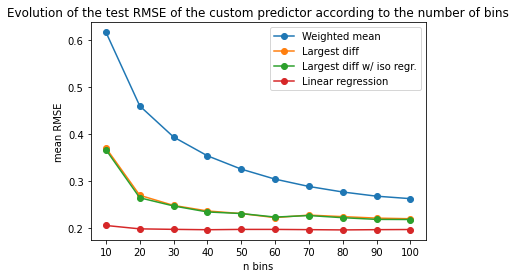

In [187]:
print('Weighted mean RMSE at 100 bins :             {0:.4f}'.format(custom_model_normal_test_rmses_list[-1]))
print('Largest diff RMSE at 100 bins :              {0:.4f}'.format(custom_model_largest_diff_test_rmses_list[-1]))
print('Largest diff w/ iso regr. RMSE at 100 bins : {0:.4f}'.format(custom_model_largest_diff_iso_regr_test_rmses_list[-1]))
print('Linear regression RMSE at 100 bins :         {0:.4f}'.format(lr_test_rmses_list[-1]))

# Plot the graph
x_axis = [str(key.split('_')[0]) for key in lr_train_rmses.keys()]

plt.plot(x_axis, custom_model_normal_test_rmses_list, linestyle='-', marker='o', label='Weighted mean')
# plt.fill_between(x_axis, custom_model_normal_test_rmses_list - np.var(custom_model_normal_test_rmses_list), custom_model_normal_test_rmses_list + np.var(custom_model_normal_test_rmses_list), alpha=0.2)

plt.plot(x_axis, custom_model_largest_diff_test_rmses_list, linestyle='-', marker='o', label='Largest diff')
# plt.fill_between(x_axis, custom_model_largest_diff_test_rmses_list - np.var(custom_model_largest_diff_test_rmses_list), custom_model_largest_diff_test_rmses_list + np.var(custom_model_largest_diff_test_rmses_list), alpha=0.2)

plt.plot(x_axis, custom_model_largest_diff_iso_regr_test_rmses_list, linestyle='-', marker='o', label='Largest diff w/ iso regr.')
# plt.fill_between(x_axis, custom_model_largest_diff_iso_regr_test_rmses_list - np.var(custom_model_largest_diff_iso_regr_test_rmses_list), custom_model_largest_diff_iso_regr_test_rmses_list + np.var(custom_model_largest_diff_iso_regr_test_rmses_list), alpha=0.2)

plt.plot(x_axis, lr_test_rmses_list, linestyle='-', marker='o', label='Linear regression')
# plt.fill_between(x_axis, lr_test_rmses_list - np.var(lr_test_rmses_list), lr_test_rmses_list + np.var(lr_test_rmses_list), alpha=0.2)

axes = plt.gca()
axes.set_xlabel('n bins')
axes.set_ylabel('mean RMSE')
axes.set_title('Evolution of the test RMSE of the custom predictor according to the number of bins')
axes.legend()

plt.show()